In [1]:
import torch
import torch.utils.data
import time
import os
import numpy as np
import csv
import dgl
from dgl.data.utils import load_graphs
import networkx as nx
from tqdm import tqdm
import random
random.seed(42)
from sklearn.model_selection import StratifiedKFold, train_test_split

class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, name, threshold=0.3, edge_ratio=0.2, node_feat_transform='pearson'):
        t0 = time.time()
        self.name = name

        G_dataset, Labels = load_graphs(name2path[self.name])

        self.node_num = G_dataset[0].ndata['N_features'].size(0)

        print("[!] Dataset: ", self.name)

        # transfer DGLHeteroGraph to DGLFormDataset
        data = []
        error_case = []
        for i in range(len(G_dataset)):
            if len(((G_dataset[i].ndata['N_features'] != 0).sum(dim=-1) == 0).nonzero()) > 0:
                error_case.append(i)
        print(error_case)
        G_dataset = [n for i, n in enumerate(G_dataset) if i not in error_case]

        for i in tqdm(range(len(G_dataset))):
            if edge_ratio:
                threshold_idx = int(len(G_dataset[i].edata['E_features']) * (1 - edge_ratio))
                threshold = sorted(G_dataset[i].edata['E_features'].tolist())[threshold_idx]

            G_dataset[i].remove_edges(torch.squeeze((torch.abs(G_dataset[i].edata['E_features']) < float(threshold)).nonzero()))
            # G_dataset[i].edata['E_features'][G_dataset[i].edata['E_features'] < 0] = 0
            G_dataset[i].edata['feat'] = G_dataset[i].edata['E_features'].unsqueeze(-1).clone()

            if name[:-7] == 'pearson' or node_feat_transform == 'original':
                G_dataset[i].ndata['feat'] = G_dataset[i].ndata['N_features'].clone()
            elif node_feat_transform == 'one_hot':
                G_dataset[i].ndata['feat'] = torch.eye(self.node_num).clone()
            elif node_feat_transform == 'pearson':
                G_dataset[i].ndata['feat'] = torch.from_numpy(np.corrcoef(G_dataset[i].ndata['N_features'].numpy())).clone()
            elif node_feat_transform == '3d_coor':
                G_dataset[i].ndata['feat'] = torch.from_numpy(self.get_3d_corr()).clone()
            elif node_feat_transform == 'degree':
                G_dataset[i].ndata['feat'] = G_dataset[i].in_degrees().unsqueeze(dim=1).clone()
                # G_dataset[i].ndata['feat'] = G_dataset[i].adj().to_dense().sum(dim=0).unsqueeze(dim=1).clone()
            elif node_feat_transform == 'adj_matrix':
                G_dataset[i].ndata['feat'] = G_dataset[i].adj().to_dense().clone()
            elif node_feat_transform == 'mean_std':
                G_dataset[i].ndata['feat'] = torch.stack(torch.std_mean(G_dataset[i].ndata['N_features'], dim=-1)).T.flip(dims=[1]).clone()
            elif node_feat_transform == 'concat':
                # [degree | pearson | mean | std | coor]
                degree = G_dataset[i].in_degrees().unsqueeze(dim=1).clone()
                pearson = torch.from_numpy(np.corrcoef(G_dataset[i].ndata['N_features'].numpy()))
                mean_std = torch.stack(torch.std_mean(G_dataset[i].ndata['N_features'], dim=-1)).T.flip(dims=[1])
                coor = torch.from_numpy(self.get_3d_corr())
                G_dataset[i].ndata['feat'] = torch.cat([degree, pearson, mean_std, coor], dim=-1).clone()
            else:
                raise NotImplementedError

            G_dataset[i].ndata.pop('N_features')
            G_dataset[i].edata.pop('E_features')
            data.append([G_dataset[i], Labels['glabel'].tolist()[i]])
        
        self.dataset = self.format_dataset(data)
        dataset = self.format_dataset(data)
        # this function splits data into train/val/test and returns the indices
        self.all_idx = self.get_all_split_idx(dataset)

        self.all = dataset
        self.train = [self.format_dataset([dataset[idx] for idx in self.all_idx['train'][split_num]]) for split_num in range(10)]
        self.val = [self.format_dataset([dataset[idx] for idx in self.all_idx['val'][split_num]]) for split_num in range(10)]
        self.test = [self.format_dataset([dataset[idx] for idx in self.all_idx['test'][split_num]]) for split_num in range(10)]
        
        print("Time taken: {:.4f}s".format(time.time()-t0))

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)
    
    def get_all_split_idx(self, dataset):
        """
            - Split total number of graphs into 3 (train, val and test) in 80:10:10
            - Stratified split proportionate to original distribution of data with respect to classes
            - Using sklearn to perform the split and then save the indexes
            - Preparing 10 such combinations of indexes split to be used in Graph NNs
            - As with KFold, each of the 10 fold have unique test set.
        """
        root_idx_dir = './data/{}/'.format(self.name)
        if not os.path.exists(root_idx_dir):
            os.makedirs(root_idx_dir)
        all_idx = {}

        # If there are no idx files, do the split and store the files
        if not (os.path.exists(root_idx_dir + 'train.index')):
            print("[!] Splitting the data into train/val/test ...")

            # Using 10-fold cross val to compare with benchmark papers
            k_splits = 10

            cross_val_fold = StratifiedKFold(n_splits=k_splits, shuffle=True)
            k_data_splits = []

            # this is a temporary index assignment, to be used below for val splitting
            for i in range(len(dataset.graph_lists)):
                dataset[i][0].a = lambda: None
                setattr(dataset[i][0].a, 'index', i)

            for indexes in cross_val_fold.split(dataset.graph_lists, dataset.graph_labels):
                remain_index, test_index = indexes[0], indexes[1]

                remain_set = self.format_dataset([dataset[index] for index in remain_index])

                # Gets final 'train' and 'val'
                train, val, _, __ = train_test_split(remain_set,
                                                     range(len(remain_set.graph_lists)),
                                                     test_size=0.111,
                                                     stratify=remain_set.graph_labels)

                train, val = self.format_dataset(train), self.format_dataset(val)
                test = self.format_dataset([dataset[index] for index in test_index])

                # Extracting only idx
                idx_train = [item[0].a.index for item in train]
                idx_val = [item[0].a.index for item in val]
                idx_test = [item[0].a.index for item in test]

                f_train_w = csv.writer(open(root_idx_dir + 'train.index', 'a+'))
                f_val_w = csv.writer(open(root_idx_dir + 'val.index', 'a+'))
                f_test_w = csv.writer(open(root_idx_dir + 'test.index', 'a+'))

                f_train_w.writerow(idx_train)
                f_val_w.writerow(idx_val)
                f_test_w.writerow(idx_test)

            print("[!] Splitting done!")

        # reading idx from the files
        for section in ['train', 'val', 'test']:
            with open(root_idx_dir + section + '.index', 'r') as f:
                reader = csv.reader(f)
                all_idx[section] = [list(map(int, idx)) for idx in reader]
        return all_idx

    def format_dataset(self, dataset):  
        """
            Utility function to recover data,
            INTO-> dgl/pytorch compatible format 
        """
        graphs = [data[0] for data in dataset]
        labels = [data[1] for data in dataset]

        for graph in graphs:
            #graph.ndata['feat'] = torch.FloatTensor(graph.ndata['feat'])
            graph.ndata['feat'] = graph.ndata['feat'].float() # dgl 4.0
            # adding edge features for Residual Gated ConvNet, if not there
            if 'feat' not in graph.edata.keys():
                edge_feat_dim = graph.ndata['feat'].shape[1] # dim same as node feature dim
                graph.edata['feat'] = torch.ones(graph.number_of_edges(), edge_feat_dim)

        return DGLFormDataset(graphs, labels)
    
    
    # form a mini batch from a given list of samples = [(graph, label) pairs]
    def collate(self, samples):
        # The input samples is a list of pairs (graph, label).
        graphs, labels = map(list, zip(*samples))
        labels = torch.tensor(np.array(labels))
        #tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
        #tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
        #snorm_n = torch.cat(tab_snorm_n).sqrt()  
        #tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))]
        #tab_snorm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
        #snorm_e = torch.cat(tab_snorm_e).sqrt()
        batched_graph = dgl.batch(graphs)
        
        return batched_graph, labels
    
    
    # prepare dense tensors for GNNs using them; such as RingGNN, 3WLGNN
    def collate_dense_gnn(self, samples):
        # The input samples is a list of pairs (graph, label).
        graphs, labels = map(list, zip(*samples))
        labels = torch.tensor(np.array(labels))
        #tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
        #tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
        #snorm_n = tab_snorm_n[0][0].sqrt()  
        
        #batched_graph = dgl.batch(graphs)
    
        g = graphs[0]
        adj = self._sym_normalize_adj(g.adjacency_matrix().to_dense())        
        """
            Adapted from https://github.com/leichen2018/Ring-GNN/
            Assigning node and edge feats::
            we have the adjacency matrix in R^{n x n}, the node features in R^{d_n} and edge features R^{d_e}.
            Then we build a zero-initialized tensor, say T, in R^{(1 + d_n + d_e) x n x n}. T[0, :, :] is the adjacency matrix.
            The diagonal T[1:1+d_n, i, i], i = 0 to n-1, store the node feature of node i. 
            The off diagonal T[1+d_n:, i, j] store edge features of edge(i, j).
        """

        zero_adj = torch.zeros_like(adj)
        
        in_dim = g.ndata['feat'].shape[1]
        
        # use node feats to prepare adj
        adj_node_feat = torch.stack([zero_adj for j in range(in_dim)])
        adj_node_feat = torch.cat([adj.unsqueeze(0), adj_node_feat], dim=0)
        
        for node, node_feat in enumerate(g.ndata['feat']):
            adj_node_feat[1:, node, node] = node_feat

        x_node_feat = adj_node_feat.unsqueeze(0)
        
        return x_node_feat, labels
    
    def _sym_normalize_adj(self, adj):
        deg = torch.sum(adj, dim = 0)#.squeeze()
        deg_inv = torch.where(deg>0, 1./torch.sqrt(deg), torch.zeros(deg.size()))
        deg_inv = torch.diag(deg_inv)
        return torch.mm(deg_inv, torch.mm(adj, deg_inv))

    def _add_self_loops(self):

        # function for adding self loops
        # this function will be called only if self_loop flag is Trueq
        for split_num in range(10):
            self.train[split_num].graph_lists = [self_loop(g) for g in self.train[split_num].graph_lists]
            self.val[split_num].graph_lists = [self_loop(g) for g in self.val[split_num].graph_lists]
            self.test[split_num].graph_lists = [self_loop(g) for g in self.test[split_num].graph_lists]
            
        for split_num in range(10):
            self.train[split_num] = DGLFormDataset(self.train[split_num].graph_lists, self.train[split_num].graph_labels)
            self.val[split_num] = DGLFormDataset(self.val[split_num].graph_lists, self.val[split_num].graph_labels)
            self.test[split_num] = DGLFormDataset(self.test[split_num].graph_lists, self.test[split_num].graph_labels)

    def get_3d_corr(self):
        path = name2path[self.name]
        with open(path, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='\n')
            if self.name not in ['abide_schaefer100', 'abide_AAL116']:
                coor = [row[1:] for row in spamreader][1:]
            else:
                coor = [row[1:] for row in spamreader]
        return np.array(coor, dtype='float')
    
class DGLFormDataset(torch.utils.data.Dataset):
    """
        DGLFormDataset wrapping graph list and label list as per pytorch Dataset.
        *lists (list): lists of 'graphs' and 'labels' with same len().
    """
    def __init__(self, *lists):
        assert all(len(lists[0]) == len(li) for li in lists)
        self.lists = lists
        self.graph_lists = lists[0]
        self.graph_labels = lists[1]

    def __getitem__(self, index):
        return tuple(li[index] for li in self.lists)

    def __len__(self):
        return len(self.lists[0])    
    
def self_loop(g):
    """
        Utility function only, to be used only when necessary as per user self_loop flag
        : Overwriting the function dgl.transform.add_self_loop() to not miss ndata['feat'] and edata['feat']
        
        
        This function is called inside a function in TUsDataset class.
    """
    new_g = dgl.DGLGraph()
    new_g.add_nodes(g.number_of_nodes())
    new_g.ndata['feat'] = g.ndata['feat']
    
    src, dst = g.all_edges(order="eid")
    src = dgl.backend.zerocopy_to_numpy(src)
    dst = dgl.backend.zerocopy_to_numpy(dst)
    non_self_edges_idx = src != dst
    # print(non_self_edges_idx)
    nodes = np.arange(g.number_of_nodes())
    new_g.add_edges(src[non_self_edges_idx], dst[non_self_edges_idx])
    new_g.add_edges(nodes, nodes)
    
    # This new edata is not used since this function gets called only for GCN, GAT
    # However, we need this for the generic requirement of ndata and edata
    new_g.edata['feat'] = torch.zeros(new_g.number_of_edges())
    return new_g

In [2]:
name2path = {
    # Put bin files here
    'Abide100Dataset': '/home/marcus/Brain-Network-Benchmark/data/Jupyter/abide_schaefer100.bin',
}

Abide100 = BrainDataset('Abide100Dataset')

  2%|▏         | 25/1025 [00:00<00:04, 245.46it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 422.15it/s]


Time taken: 2.9856s


## Dataset Exploration

### Basic Import and Dataset Stats

In [3]:
# Checking the label distribution within the dataset

def label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    print("Label distribution:", distribution)

# Assuming labels are stored in a list or similar structure
label_distribution([label for _, label in Abide100.dataset])

# Access the first graph and its label
graph, label = Abide100[0]
print("\n\nGraph:", graph)
print("Label:", label)

# Print some properties
print("\n\nNumber of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())
print("Node features shape:", graph.ndata['feat'].shape)
print("Edge features shape:", graph.edata['feat'].shape)

print("\n\nNumber of graphs in training set:", len(Abide100.train[1]))
print("Number of graphs in validation set:", len(Abide100.val[0]))
print("Number of graphs in test set:", len(Abide100.test[0]))

# Checking number of graphs in the dataset
# One graph is one patient
print("\n\nTotal number of graphs in the dataset:", len(Abide100))
# Assuming binary or categorical labels
unique_labels = set([Abide100[i][1] for i in range(len(Abide100))])
print("Unique labels in the dataset:", unique_labels)

Label distribution: {0: 537, 1: 488}


Graph: Graph(num_nodes=100, num_edges=3430,
      ndata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
Label: 0


Number of nodes: 100
Number of edges: 3430
Node features shape: torch.Size([100, 100])
Edge features shape: torch.Size([3430, 1])


Number of graphs in training set: 819
Number of graphs in validation set: 103
Number of graphs in test set: 103


Total number of graphs in the dataset: 1025
Unique labels in the dataset: {0, 1}


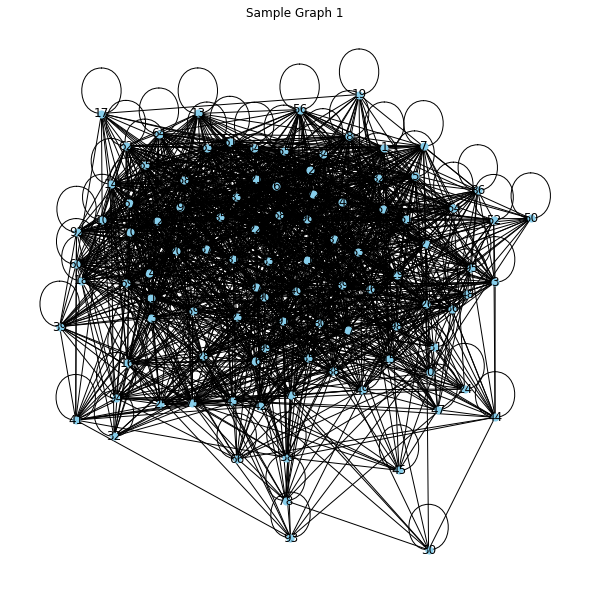

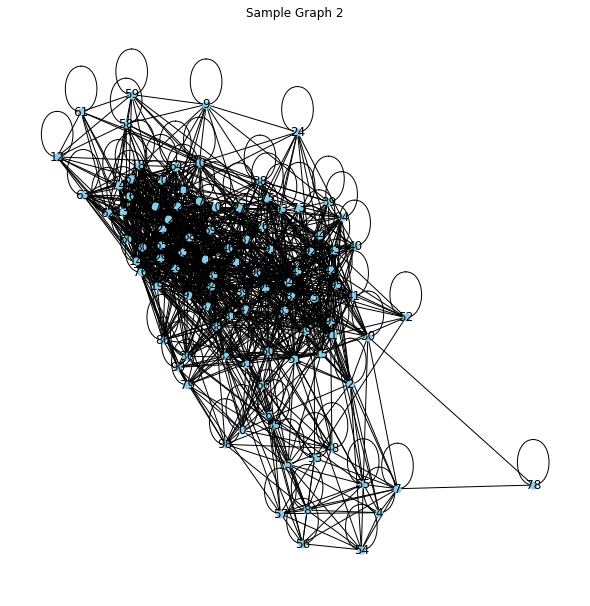

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(dgl_graph, title="Graph Visualization"):
    # Convert DGL graph to NetworkX graph
    nx_graph = dgl_graph.to_networkx().to_undirected()
    
    # Draw the graph
    plt.figure(figsize=(8, 8))
    nx.draw(nx_graph, with_labels=True, node_color='skyblue', node_size=50, edge_color='k')
    plt.title(title)
    plt.show()

# Select a few sample graphs from the dataset
sample_graphs = [Abide100.dataset[i][0] for i in range(2)]  # Adjust indices as needed

# Visualize the selected samples
for i, graph in enumerate(sample_graphs):
    visualize_graph(graph, title=f"Sample Graph {i+1}")

In [5]:
# Compare the statistical properties of node and edge features for graphs with label 0 vs. label 1. Calculate means, variances, and other relevant statistics for each group.

def graph_feature_statistics(dataset):
    features_0 = {'node': [], 'edge': []}
    features_1 = {'node': [], 'edge': []}

    for graph, label in dataset:
        node_features = graph.ndata['feat']
        edge_features = graph.edata['feat']

        if label == 0:
            features_0['node'].append(node_features.mean().item())
            features_0['edge'].append(edge_features.mean().item())
        else:
            features_1['node'].append(node_features.mean().item())
            features_1['edge'].append(edge_features.mean().item())

    # Calculate and print statistics for each label
    for label, stats in [('0', features_0), ('1', features_1)]:
        print(f"Label {label} - Average node feature value: {np.mean(stats['node']):.4f}")
        print(f"Label {label} - Average edge feature value: {np.mean(stats['edge']):.4f}")

        
# Analyze graph-specific metrics such as average path length, clustering coefficient, and centrality measures for each label group.

def graph_topology_metrics(dataset):
    topology_metrics_0 = {'avg_path_length': [], 'clustering_coefficient': []}
    topology_metrics_1 = {'avg_path_length': [], 'clustering_coefficient': []}

    for graph, label in dataset:
        # Convert DGL graph to NetworkX graph
        nx_graph = graph.to_networkx().to_undirected()
        # Convert multigraph to a simple graph
        simple_graph = nx.Graph(nx_graph)

        # The clustering coefficient can be undefined if the graph is not connected
        # so we need to handle exceptions
        try:
            avg_path_length = nx.average_shortest_path_length(simple_graph)
        except nx.NetworkXError:
            avg_path_length = float('inf')  # or some other value that indicates undefined

        clustering_coeff = nx.average_clustering(simple_graph)

        if label == 0:
            topology_metrics_0['avg_path_length'].append(avg_path_length)
            topology_metrics_0['clustering_coefficient'].append(clustering_coeff)
        else:
            topology_metrics_1['avg_path_length'].append(avg_path_length)
            topology_metrics_1['clustering_coefficient'].append(clustering_coeff)

    # Calculate and print statistics for each label
    for label, metrics in [('0', topology_metrics_0), ('1', topology_metrics_1)]:
        print(f"\n\nLabel {label} - Average path length: {np.mean([l for l in metrics['avg_path_length'] if l != float('inf')]):.4f}")
        print(f"Label {label} - Average clustering coefficient: {np.mean(metrics['clustering_coefficient']):.4f}")

        
        

graph_feature_statistics(Abide100.dataset)
graph_topology_metrics(Abide100.dataset)

Label 0 - Average node feature value: 0.0483
Label 0 - Average edge feature value: 0.1509
Label 1 - Average node feature value: 0.0508
Label 1 - Average edge feature value: 0.1546


Label 0 - Average path length: 1.7269
Label 0 - Average clustering coefficient: 0.5069


Label 1 - Average path length: 1.7302
Label 1 - Average clustering coefficient: 0.5067


### Degree Distribution
#### Dataset built from correlation matrices

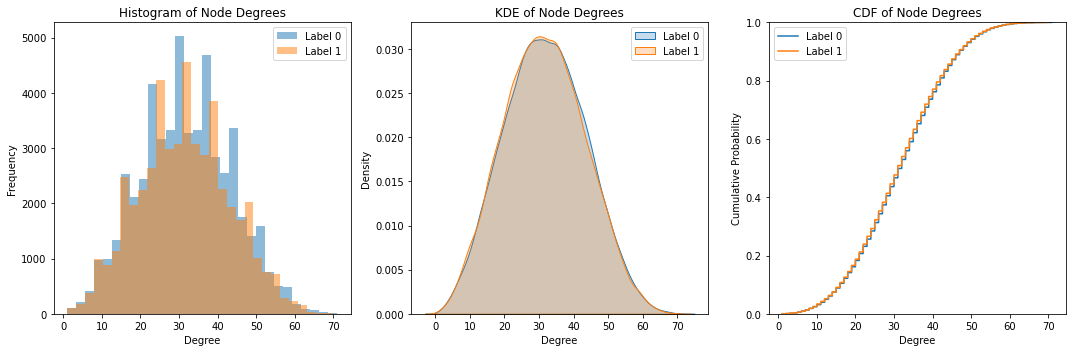

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def node_degree_analysis(dataset):
    degree_dist_0 = []
    degree_dist_1 = []

    for graph, label in dataset:
        degrees = graph.in_degrees().float()
        if label == 0:
            degree_dist_0.extend(degrees.tolist())
        else:
            degree_dist_1.extend(degrees.tolist())

    # Visualization code
    plt.figure(figsize=(15, 5))

    # Histogram
    plt.subplot(1, 3, 1)
    plt.hist(degree_dist_0, bins=30, alpha=0.5, label='Label 0')
    plt.hist(degree_dist_1, bins=30, alpha=0.5, label='Label 1')
    plt.title('Histogram of Node Degrees')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()

    # KDE
    plt.subplot(1, 3, 2)
    sns.kdeplot(degree_dist_0, shade=True, label='Label 0')
    sns.kdeplot(degree_dist_1, shade=True, label='Label 1')
    plt.title('KDE of Node Degrees')
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.legend()

    # CDF
    plt.subplot(1, 3, 3)
    sns.ecdfplot(degree_dist_0, label='Label 0')
    sns.ecdfplot(degree_dist_1, label='Label 1')
    plt.title('CDF of Node Degrees')
    plt.xlabel('Degree')
    plt.ylabel('Cumulative Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()

node_degree_analysis(Abide100.dataset)

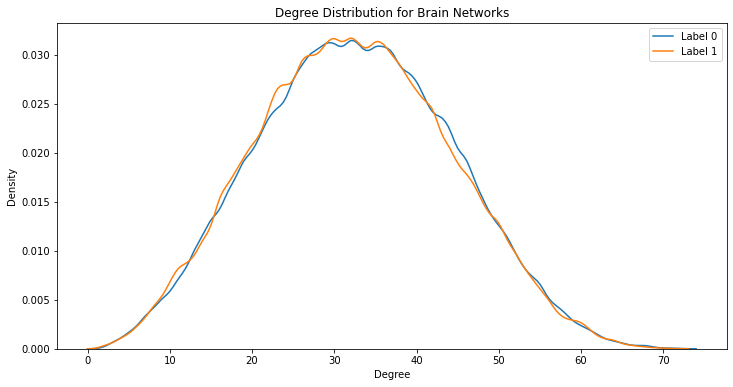

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import dgl
import torch

def calculate_graph_degrees(graph):
    # Convert DGL graph to networkx graph
    nx_graph = dgl.to_networkx(graph)
    # Convert to undirected graph if it's not already
    nx_graph = nx_graph.to_undirected()
    # Calculate degrees
    degrees = [deg for node, deg in nx_graph.degree()]
    return degrees

def plot_degree_distribution(graphs, labels, title):
    # Prepare the degree list by labels
    degrees_by_label = {0: [], 1: []}
    
    for graph, label in zip(graphs, labels):
        degrees = calculate_graph_degrees(graph)
        degrees_by_label[label].extend(degrees)
    
    # Plotting the degree distribution
    plt.figure(figsize=(12, 6))
    sns.kdeplot(degrees_by_label[0], label='Label 0', bw_adjust=0.5)
    sns.kdeplot(degrees_by_label[1], label='Label 1', bw_adjust=0.5)
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()

# Assuming 'Abide100' is the BrainDataset object you've created
# We need to access the underlying graphs and labels for the entire dataset
graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]

# Plotting the degree distribution for the dataset
plot_degree_distribution(graphs, labels, 'Degree Distribution for Brain Networks')


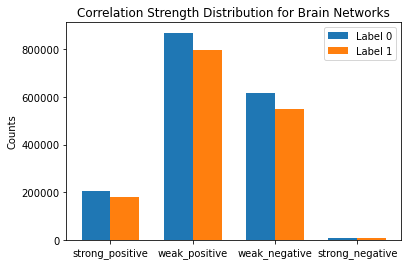

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dgl

def categorize_correlation_strength(graph):
    # Extract edge weights (correlation values)
    edge_weights = graph.edata['feat'].numpy()
    
    # Define the bins for correlation strength
    bins = {
        'strong_positive': (0.5, 1.0),
        'weak_positive': (0, 0.5),
        'weak_negative': (-0.5, 0),
        'strong_negative': (-1.0, -0.5)
    }
    
    # Categorize the correlations
    categorized_correlations = {category: 0 for category in bins}
    
    for weight in edge_weights:
        for category, (lower_bound, upper_bound) in bins.items():
            if lower_bound < weight <= upper_bound:
                categorized_correlations[category] += 1
                break
                
    return categorized_correlations

def plot_correlation_strength_distribution(graphs, labels, title):
    # Prepare the correlation strength counts by labels
    correlation_strength_by_label = {0: {category: 0 for category in ['strong_positive', 'weak_positive', 'weak_negative', 'strong_negative']},
                                     1: {category: 0 for category in ['strong_positive', 'weak_positive', 'weak_negative', 'strong_negative']}}
    
    # Categorize the correlations for each graph and aggregate the counts
    for graph, label in zip(graphs, labels):
        categorized_correlations = categorize_correlation_strength(graph)
        for category in categorized_correlations:
            correlation_strength_by_label[label][category] += categorized_correlations[category]
    
    # Data preparation for plotting
    categories = ['strong_positive', 'weak_positive', 'weak_negative', 'strong_negative']
    label_0_counts = [correlation_strength_by_label[0][category] for category in categories]
    label_1_counts = [correlation_strength_by_label[1][category] for category in categories]
    
    # Plotting the correlation strength distribution
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, label_0_counts, width, label='Label 0')
    rects2 = ax.bar(x + width/2, label_1_counts, width, label='Label 1')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    plt.show()

# Assuming 'Abide100' is the BrainDataset object you've created
# We need to access the underlying graphs and labels for the entire dataset
graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]

# Plotting the correlation strength distribution for the dataset
plot_correlation_strength_distribution(graphs, labels, 'Correlation Strength Distribution for Brain Networks')

##### Here, we observe strong positive and strong negative correlations are more prevalent in one label over the other, which could indicate more synchronized activity in certain brain regions -- might be associated with the condition that the label represents.

#### We want to do 2 things here. 

Correlation Strength Analysis: Calculate and compare the distribution of correlation strengths across different labels.

Weighted Degree Analysis: Calculate the weighted degree (strength) of nodes using edge weights and compare these between different labels.

In [9]:
import numpy as np
import torch
from scipy.stats import ttest_ind

def analyze_strong_positive_correlations(graphs, labels):
    strong_positive_threshold = 0.5  # define threshold for strong positive correlation
    strong_positive_counts = {0: [], 1: []}

    for graph, label in zip(graphs, labels):
        # Get the edge weights (correlations) as a flattened array
        edge_weights = graph.edata['feat'].squeeze().numpy()
        
        # Count the number of strong positive correlations
        count_strong_positive = np.sum(edge_weights > strong_positive_threshold)
        strong_positive_counts[label].append(count_strong_positive)

    # Perform t-test to compare the counts of strong positive correlations
    t_stat, p_value = ttest_ind(strong_positive_counts[0], strong_positive_counts[1])
    
    return t_stat, p_value, strong_positive_counts

graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]

# Analyze strong positive correlations
t_stat, p_value, strong_positive_counts = analyze_strong_positive_correlations(graphs, labels)
print(f"t-Statistic: {t_stat}, p-value: {p_value}")

t-Statistic: 1.2724239857686155, p-value: 0.2035116470685948


The p-value obtained (0.2035) is higher than the typical significance level of 0.05, which indicates that there is no statistically significant difference in the prevalence of strong positive correlations between the two groups at the 95% confidence level. This suggests that while there may be observable differences in the correlation strength distribution, they are not statistically significant with the current dataset size or distribution.

In [10]:
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.stats.multitest as multi

def calculate_weighted_degrees(graph):
    degrees = graph.in_degrees().float().numpy()
    edge_weights = graph.edata['feat'].numpy()
    weighted_degrees = degrees * edge_weights
    return np.sum(weighted_degrees, axis=0)

def compare_weighted_degrees(graphs, labels):
    weighted_degrees = {0: [], 1: []}

    # Aggregate weighted degrees for all graphs
    for graph, label in zip(graphs, labels):
        w_degrees = calculate_weighted_degrees(graph)
        weighted_degrees[label].append(w_degrees)

    # Convert lists to numpy arrays for easier manipulation
    weighted_degrees[0] = np.array(weighted_degrees[0])
    weighted_degrees[1] = np.array(weighted_degrees[1])

    # Perform t-tests for each node
    p_values = []
    t_statistics = []
    node_indices = np.arange(weighted_degrees[0].shape[1])
    for node_index in node_indices:
        t_stat, p_val = ttest_ind(weighted_degrees[0][:, node_index], weighted_degrees[1][:, node_index])
        t_statistics.append(t_stat)
        p_values.append(p_val)

    # Adjust p-values for multiple comparisons if needed
    # _, corrected_p_values, _, _ = multi.multipletests(p_values, method='bonferroni')

    # Get significant results
    significant_indices = [i for i, p_val in enumerate(p_values) if p_val < 0.05]
    significant_p_values = [p_values[i] for i in significant_indices]

    # Sort by p-value and return top 10 (or as needed)
    sorted_significant_indices = sorted(range(len(significant_p_values)), key=lambda i: significant_p_values[i])
    top_indices = [significant_indices[i] for i in sorted_significant_indices[:10]]

    return top_indices, significant_p_values, p_values, t_statistics

# Call the function and print the results
graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]

top_indices, significant_p_values, p_values, t_statistics = compare_weighted_degrees(graphs, labels)

# Sort the significant nodes by their p-values
sorted_nodes = sorted(zip(top_indices, significant_p_values, t_statistics), key=lambda x: x[1])

print("Nodes with significant differences in weighted degrees:")
for i, (node_idx, p_val, t_stat) in enumerate(sorted_nodes):
    print(f"Node {node_idx}: p-value = {p_val}, t-statistic = {t_stat}")
    if i >= 20:  # Only print top 10
        break

Nodes with significant differences in weighted degrees:
Node 1: p-value = 0.0003135520944362765, t-statistic = -1.3240271600969884
Node 26: p-value = 0.0004106288485103457, t-statistic = 0.5895802297687565
Node 59: p-value = 0.007885713149556186, t-statistic = 1.898961180897967
Node 79: p-value = 0.009722848041887184, t-statistic = 0.15316422243433378
Node 35: p-value = 0.01111291806090598, t-statistic = -2.5437569169275838
Node 31: p-value = 0.013607211157007077, t-statistic = 2.4717500351269117
Node 43: p-value = 0.021946465784962267, t-statistic = 0.07905329112751201
Node 0: p-value = 0.02621468875356726, t-statistic = 0.6520915054660382
Node 37: p-value = 0.030088043308885672, t-statistic = -0.20370649603442814
Node 88: p-value = 0.04922549569605715, t-statistic = 0.8019712458952293


In [11]:
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

def analyze_significant_nodes(graphs, labels, significant_nodes):
    node_connectivity = {node: {0: [], 1: []} for node in significant_nodes}
    
    # Iterate over each graph and label
    for graph, label in zip(graphs, labels):
        # Converting to NetworkX graph for analysis
        g_nx = dgl.to_networkx(graph).to_undirected()
        
        # For each significant node, calculate its weighted connectivity in the graph
        for node in significant_nodes:
            connectivity = 0
            for u, v in g_nx.edges(node):
                # Check if 'feat' attribute exists
                data = g_nx[u][v].get('feat')
                if data is not None:
                    connectivity += data.item()
            node_connectivity[node][label].append(connectivity)
    
    return node_connectivity


def perform_statistical_tests(node_connectivity):
    results = {}
    for node in node_connectivity:
        # Separate connectivity values by label
        values_label_0 = node_connectivity[node][0]
        values_label_1 = node_connectivity[node][1]
        
        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(values_label_0, values_label_1, alternative='two-sided')
        results[node] = {'statistic': stat, 'p_value': p_value}
        
        # Print results
        print(f"Node {node}: U-statistic = {stat}, p-value = {p_value}")
    
    return results

# Retrieve the graphs and labels from your dataset
graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]

# Significant nodes identified from previous analysis
significant_nodes = [1, 26, 59, 79, 35, 31, 43, 0, 37, 88]

# Perform the analysis on significant nodes
node_connectivity = analyze_significant_nodes(graphs, labels, significant_nodes)

# Perform statistical tests on node connectivity
statistical_results = perform_statistical_tests(node_connectivity)

# Visualize the results
def visualize_connectivity_results(node_connectivity, significant_nodes):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, node in enumerate(significant_nodes):
        ax = axes[i]
        connectivity_label_0 = node_connectivity[node][0]
        connectivity_label_1 = node_connectivity[node][1]
        
        ax.hist(connectivity_label_0, bins=20, alpha=0.5, label='Label 0')
        ax.hist(connectivity_label_1, bins=20, alpha=0.5, label='Label 1')
        ax.set_title(f'Node {node} Connectivity')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

visualize_connectivity_results(node_connectivity, significant_nodes)


ValueError: All numbers are identical in mannwhitneyu

In [12]:
def calculate_centrality_measures(graphs, significant_nodes):
    centrality_measures = {
        node: {'degree_centrality': [], 'closeness_centrality': [], 'betweenness_centrality': []}
        for node in significant_nodes
    }
    
    # Iterate over each graph
    for graph in graphs:
        g_nx = dgl.to_networkx(graph).to_undirected()
        
        # Calculate centrality measures for significant nodes
        degree_centrality = nx.degree_centrality(g_nx)
        closeness_centrality = nx.closeness_centrality(g_nx)
        betweenness_centrality = nx.betweenness_centrality(g_nx)
        
        for node in significant_nodes:
            centrality_measures[node]['degree_centrality'].append(degree_centrality.get(node, 0))
            centrality_measures[node]['closeness_centrality'].append(closeness_centrality.get(node, 0))
            centrality_measures[node]['betweenness_centrality'].append(betweenness_centrality.get(node, 0))
    
    return centrality_measures

# Calculate centrality measures for significant nodes
centrality_measures = calculate_centrality_measures(graphs, significant_nodes)

Summary for degree_centrality:
Node 1: Mean = 0.3195, Std Dev = 0.1228
Node 26: Mean = 0.3251, Std Dev = 0.1104
Node 59: Mean = 0.3154, Std Dev = 0.0965
Node 79: Mean = 0.2810, Std Dev = 0.1194
Node 35: Mean = 0.3164, Std Dev = 0.1048
Node 31: Mean = 0.2639, Std Dev = 0.1169
Node 43: Mean = 0.3616, Std Dev = 0.1291
Node 0: Mean = 0.2257, Std Dev = 0.1145
Node 37: Mean = 0.3508, Std Dev = 0.1335
Node 88: Mean = 0.3441, Std Dev = 0.1041


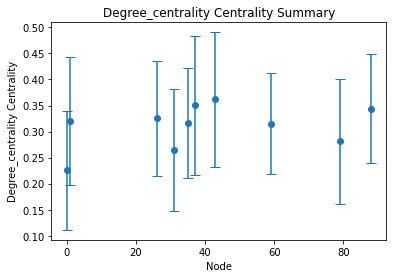

Summary for closeness_centrality:
Node 1: Mean = 0.5762, Std Dev = 0.0643
Node 26: Mean = 0.5825, Std Dev = 0.0509
Node 59: Mean = 0.5773, Std Dev = 0.0454
Node 79: Mean = 0.5628, Std Dev = 0.0608
Node 35: Mean = 0.5781, Std Dev = 0.0499
Node 31: Mean = 0.5556, Std Dev = 0.0595
Node 43: Mean = 0.5961, Std Dev = 0.0661
Node 0: Mean = 0.5339, Std Dev = 0.0769
Node 37: Mean = 0.5917, Std Dev = 0.0677
Node 88: Mean = 0.5905, Std Dev = 0.0462


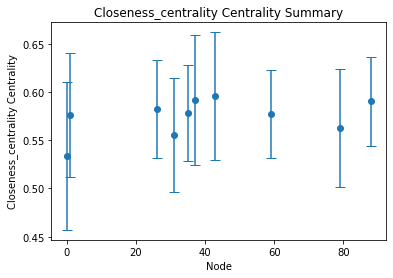

Summary for betweenness_centrality:
Node 1: Mean = 0.0075, Std Dev = 0.0062
Node 26: Mean = 0.0072, Std Dev = 0.0050
Node 59: Mean = 0.0064, Std Dev = 0.0043
Node 79: Mean = 0.0066, Std Dev = 0.0062
Node 35: Mean = 0.0070, Std Dev = 0.0046
Node 31: Mean = 0.0059, Std Dev = 0.0058
Node 43: Mean = 0.0087, Std Dev = 0.0054
Node 0: Mean = 0.0043, Std Dev = 0.0041
Node 37: Mean = 0.0094, Std Dev = 0.0059
Node 88: Mean = 0.0087, Std Dev = 0.0056


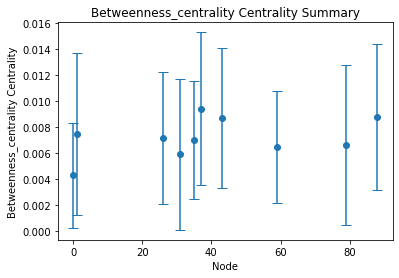

In [13]:
import matplotlib.pyplot as plt

# Function to summarize and plot centrality measures
def summarize_and_plot_centrality(centrality_measures, centrality_type):
    print(f"Summary for {centrality_type}:")
    
    # Create a dictionary to store summary statistics
    summary_stats = {}

    for node, measures in centrality_measures.items():
        # Calculate mean and standard deviation for each node's centrality
        mean_centrality = np.mean(measures[centrality_type])
        std_centrality = np.std(measures[centrality_type])

        # Store in summary_stats
        summary_stats[node] = (mean_centrality, std_centrality)

        # Print summary
        print(f"Node {node}: Mean = {mean_centrality:.4f}, Std Dev = {std_centrality:.4f}")

    # Plotting
    nodes = list(summary_stats.keys())
    means = [summary_stats[node][0] for node in nodes]
    std_devs = [summary_stats[node][1] for node in nodes]

    plt.errorbar(nodes, means, yerr=std_devs, fmt='o', capsize=5)
    plt.title(f'{centrality_type.capitalize()} Centrality Summary')
    plt.xlabel('Node')
    plt.ylabel(f'{centrality_type.capitalize()} Centrality')
    plt.show()

# Call the function for degree centrality
summarize_and_plot_centrality(centrality_measures, 'degree_centrality')

# Repeat for closeness and betweenness
summarize_and_plot_centrality(centrality_measures, 'closeness_centrality')
summarize_and_plot_centrality(centrality_measures, 'betweenness_centrality')

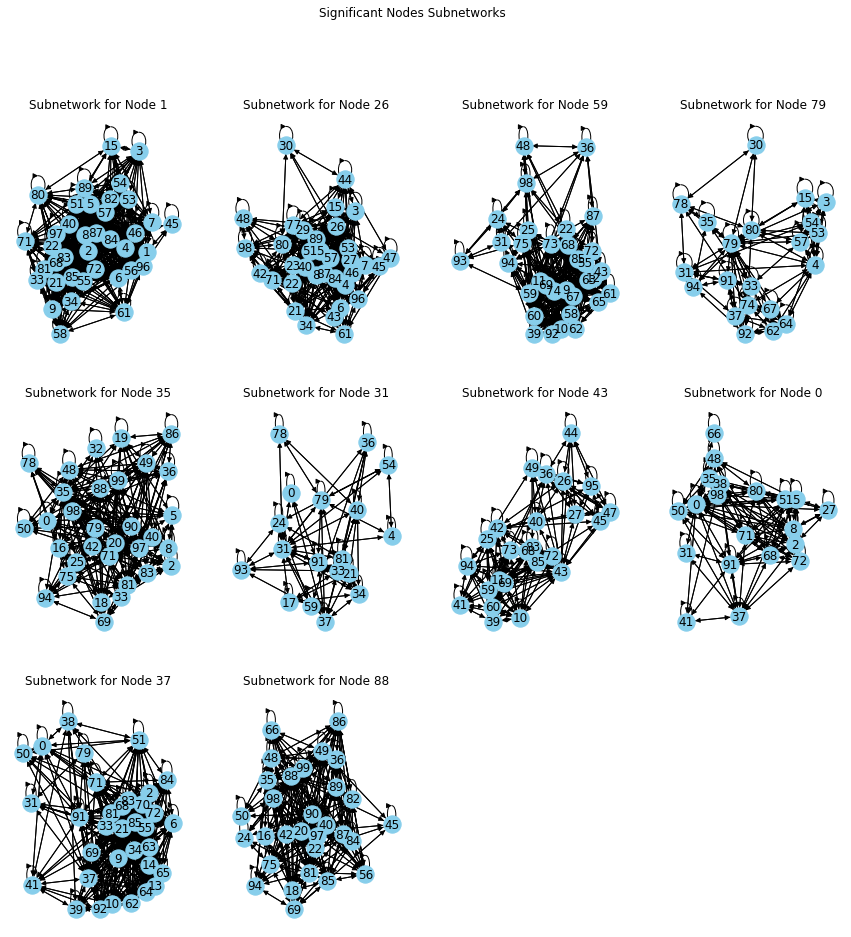

In [14]:
import matplotlib.pyplot as plt

significant_nodes = [1, 26, 59, 79, 35, 31, 43, 0, 37, 88]

def visualize_subnetworks(graph, significant_nodes, title):
    # Convert DGL graph to NetworkX graph
    g_nx = dgl.to_networkx(graph, edge_attrs=['feat'])
    
    # Extract subnetworks containing the significant nodes
    subgraphs = []
    for node in significant_nodes:
        subgraphs.append(nx.ego_graph(g_nx, node, radius=1))  # Adjust radius as needed
    
    # Draw the subnetworks
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(g_nx)  # Positional layout of nodes
    for i, sg in enumerate(subgraphs, start=1):
        plt.subplot(3, 4, i)  # Adjust grid dimensions as needed
        nx.draw(sg, pos, with_labels=True, node_color='skyblue', edge_color='k')
        plt.title(f'Subnetwork for Node {significant_nodes[i-1]}')
    
    plt.suptitle(title)
    plt.show()

# Visualize subnetworks for a single graph as an example
example_graph = graphs[0]  # Replace with the graph you want to visualize
visualize_subnetworks(example_graph, significant_nodes, 'Significant Nodes Subnetworks')

In [15]:
import networkx as nx
import dgl

def verify_graph_conversion(dgl_graph):
    nx_graph = dgl.to_networkx(dgl_graph).to_undirected()
    # Only check node count, since edge count might differ for valid reasons
    assert dgl_graph.number_of_nodes() == nx_graph.number_of_nodes(), "Node counts differ after conversion."
    # Optionally, log edge counts for manual review
    dgl_edges = dgl_graph.number_of_edges()
    nx_edges = nx_graph.number_of_edges()
    print(f"DGL edges: {dgl_edges}, NetworkX edges (after conversion): {nx_edges}")
    return nx_graph

def compute_and_check_centrality(nx_graph, significant_nodes):
    # Compute centrality measures
    degree_centrality = nx.degree_centrality(nx_graph)
    # Check for zero variance
    centrality_values = [degree_centrality[node] for node in significant_nodes]
    assert np.var(centrality_values) > 0, "Centrality measures have zero variance."
    return degree_centrality

def check_for_nans(centrality_measures):
    for node, value in centrality_measures.items():
        # Check if value is nan
        assert not np.isnan(value), f"Centrality measure for node {node} is nan."

# Use these functions in your workflow
for dgl_graph in graphs:
    nx_graph = verify_graph_conversion(dgl_graph)
    centrality_measures = compute_and_check_centrality(nx_graph, significant_nodes)
    check_for_nans(centrality_measures)

DGL edges: 3430, NetworkX edges (after conversion): 1765
DGL edges: 2374, NetworkX edges (after conversion): 1237
DGL edges: 3694, NetworkX edges (after conversion): 1897
DGL edges: 2416, NetworkX edges (after conversion): 1258
DGL edges: 3368, NetworkX edges (after conversion): 1734
DGL edges: 3226, NetworkX edges (after conversion): 1663
DGL edges: 3168, NetworkX edges (after conversion): 1634
DGL edges: 3682, NetworkX edges (after conversion): 1891
DGL edges: 3108, NetworkX edges (after conversion): 1604
DGL edges: 2658, NetworkX edges (after conversion): 1379
DGL edges: 2964, NetworkX edges (after conversion): 1532
DGL edges: 3220, NetworkX edges (after conversion): 1660
DGL edges: 3248, NetworkX edges (after conversion): 1674
DGL edges: 2810, NetworkX edges (after conversion): 1455
DGL edges: 3278, NetworkX edges (after conversion): 1689
DGL edges: 3744, NetworkX edges (after conversion): 1922
DGL edges: 3014, NetworkX edges (after conversion): 1557
DGL edges: 3244, NetworkX edges

DGL edges: 3212, NetworkX edges (after conversion): 1656
DGL edges: 3758, NetworkX edges (after conversion): 1929
DGL edges: 3148, NetworkX edges (after conversion): 1624
DGL edges: 3342, NetworkX edges (after conversion): 1721
DGL edges: 2178, NetworkX edges (after conversion): 1139
DGL edges: 3152, NetworkX edges (after conversion): 1626
DGL edges: 2886, NetworkX edges (after conversion): 1493
DGL edges: 3508, NetworkX edges (after conversion): 1804
DGL edges: 2396, NetworkX edges (after conversion): 1248
DGL edges: 2460, NetworkX edges (after conversion): 1280
DGL edges: 3372, NetworkX edges (after conversion): 1736
DGL edges: 2362, NetworkX edges (after conversion): 1231
DGL edges: 2194, NetworkX edges (after conversion): 1147
DGL edges: 3472, NetworkX edges (after conversion): 1786
DGL edges: 2938, NetworkX edges (after conversion): 1519
DGL edges: 2490, NetworkX edges (after conversion): 1295
DGL edges: 2124, NetworkX edges (after conversion): 1112
DGL edges: 2538, NetworkX edges

### Exploring centrality

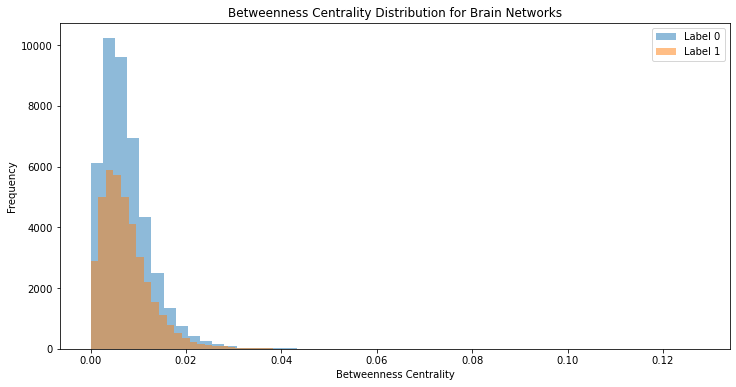

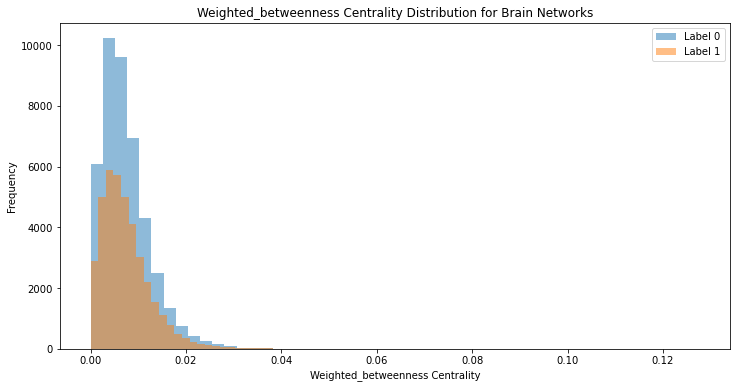

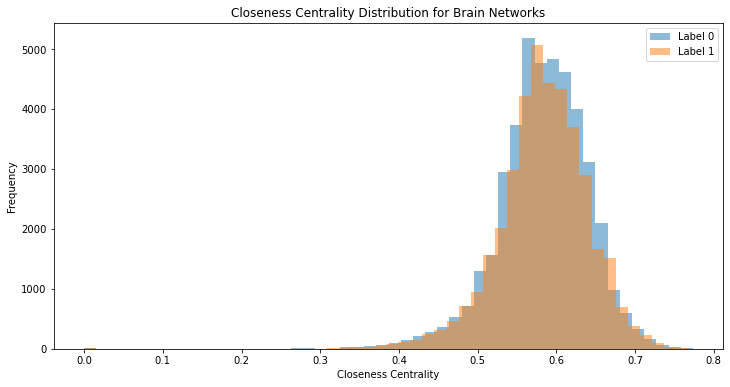

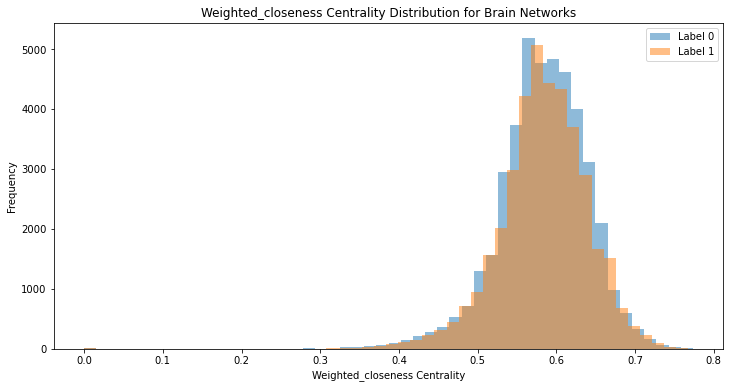

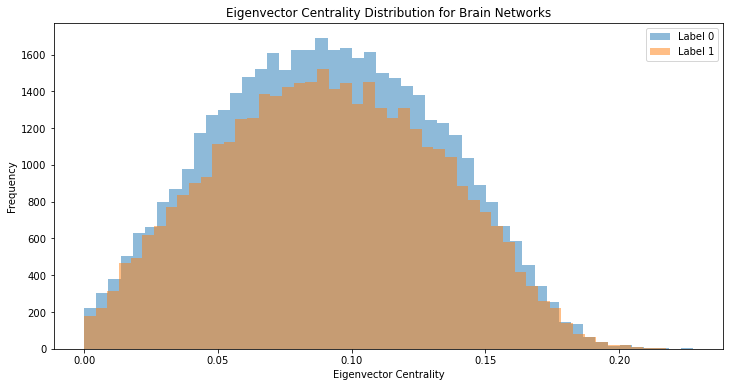

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import numpy as np

# Assuming 'Abide100' is your BrainDataset instance
train_graphs, train_labels = [], []
for graph, label in Abide100.train[0]:  # Adjust the index for different splits
    train_graphs.append(graph)
    train_labels.append(label)

def compute_centrality_measures(graphs, labels):
    centrality_measures = {
        'betweenness': {0: [], 1: []},
        'weighted_betweenness': {0: [], 1: []},
        'closeness': {0: [], 1: []},
        'weighted_closeness': {0: [], 1: []},
        'eigenvector': {0: [], 1: []}
    }
    
    for graph, label in zip(graphs, labels):
        # Convert to networkx graph and then to simple graph with averaged edge weights
        nx_multigraph = dgl.to_networkx(graph).to_undirected()
        nx_graph = nx.Graph()
        for u, v, data in nx_multigraph.edges(data=True):
            w = data['weight'] if 'weight' in data else 1.0
            if nx_graph.has_edge(u, v):
                nx_graph[u][v]['weight'] += w
                nx_graph[u][v]['count'] += 1
            else:
                nx_graph.add_edge(u, v, weight=w, count=1)
        
        # Average the weights
        for u, v, data in nx_graph.edges(data=True):
            data['weight'] /= data['count']
        
        # Compute centrality measures for the networkx graph
        betweenness = nx.betweenness_centrality(nx_graph, weight='weight')
        closeness = nx.closeness_centrality(nx_graph, distance='weight')
        eigenvector = nx.eigenvector_centrality(nx_graph, max_iter=1000, tol=1e-06, weight='weight')
        weighted_betweenness = nx.betweenness_centrality(nx_graph, weight='weight', normalized=True)
        weighted_closeness = nx.closeness_centrality(nx_graph, distance='weight')  # Compute weighted closeness
        
        # Aggregate the centrality values by label
        centrality_measures['betweenness'][label].extend(betweenness.values())
        centrality_measures['closeness'][label].extend(closeness.values())
        centrality_measures['eigenvector'][label].extend(eigenvector.values())
        centrality_measures['weighted_betweenness'][label].extend(weighted_betweenness.values())
        centrality_measures['weighted_closeness'][label].extend(weighted_closeness.values())  # Add weighted closeness values
    
    return centrality_measures



def plot_centrality_distributions(centrality_measures, measure_name):
    # Data to plot
    data_label_0 = centrality_measures[measure_name][0]
    data_label_1 = centrality_measures[measure_name][1]
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.hist(data_label_0, bins=50, alpha=0.5, label='Label 0')
    plt.hist(data_label_1, bins=50, alpha=0.5, label='Label 1')
    plt.xlabel(measure_name.capitalize() + ' Centrality')
    plt.ylabel('Frequency')
    plt.title(measure_name.capitalize() + ' Centrality Distribution for Brain Networks')
    plt.legend()
    plt.show()

# Assuming 'Abide100' is the BrainDataset object you've created
graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]

# Compute centrality measures for the training set
centrality_measures = compute_centrality_measures(train_graphs, train_labels)

# Plot distributions for each centrality measure for the training set
for measure_name in centrality_measures.keys():
    plot_centrality_distributions(centrality_measures, measure_name)

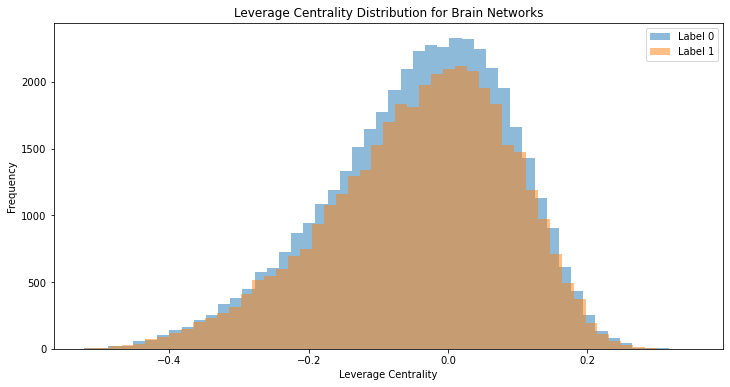

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import numpy as np

def compute_leverage_centrality(graph):
    """
    Compute the leverage centrality for each node in a NetworkX graph.
    """
    leverage_centrality = {}
    for node in graph.nodes():
        node_degree = graph.degree(node)
        neighbors = list(graph.neighbors(node))
        if node_degree == 0:  # Avoid division by zero for isolated nodes
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

def compute_and_plot_leverage_centrality_for_dataset(graphs, labels):
    leverage_centrality_values = {0: [], 1: []}
    
    for graph, label in zip(graphs, labels):
        nx_graph = dgl.to_networkx(graph).to_undirected()
        leverage_centrality = compute_leverage_centrality(nx_graph)
        leverage_centrality_values[label].extend(leverage_centrality.values())
    
    # Plotting
    plt.figure(figsize=(12, 6))
    for label, values in leverage_centrality_values.items():
        plt.hist(values, bins=50, alpha=0.5, label=f'Label {label}')
    plt.xlabel('Leverage Centrality')
    plt.ylabel('Frequency')
    plt.title('Leverage Centrality Distribution for Brain Networks')
    plt.legend()
    plt.show()

# Assuming 'Abide100' is the BrainDataset instance
train_graphs, train_labels = [], []
for graph, label in Abide100.train[0]:  # Adjust the index for different splits
    train_graphs.append(graph)
    train_labels.append(label)

# Compute and plot leverage centrality for the training dataset
compute_and_plot_leverage_centrality_for_dataset(train_graphs, train_labels)


### Differential Network Analysis

In [18]:
import numpy as np
import dgl
import torch
from scipy.stats import ttest_ind

# Function to aggregate graphs by label
def aggregate_graphs_by_label(graphs, labels):
    # Create dictionaries to hold aggregate adjacency matrices and node counts
    agg_adj_matrices = {0: None, 1: None}
    node_counts = {0: 0, 1: 0}
    
    # Loop over all graphs and labels
    for graph, label in zip(graphs, labels):
        adj_matrix = graph.adj().to_dense().numpy()  # Convert the graph to an adjacency matrix
        if agg_adj_matrices[label] is None:
            agg_adj_matrices[label] = adj_matrix
        else:
            agg_adj_matrices[label] += adj_matrix  # Sum the adjacency matrices for each label
        node_counts[label] += 1
    
    # Average the adjacency matrices by the number of graphs for each label
    for label in agg_adj_matrices:
        agg_adj_matrices[label] /= node_counts[label]
    
    return agg_adj_matrices

# Aggregate the graphs by label
graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]
agg_adj_matrices = aggregate_graphs_by_label(graphs, labels)

In [19]:
# Function to perform a t-test on the edges of the graphs
def differential_edge_test(graphs, labels):
    edge_diff = {}
    num_nodes = graphs[0].number_of_nodes()
    
    # Initialize the dictionary to hold p-values and t-statistics
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:  # Ignore self-loops
                edge_diff[(i, j)] = {'t_stat': None, 'p_val': None}
    
    # Perform t-tests on each edge
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                # Extract the edge weights for this edge across all graphs
                edge_weights_0 = [graph.adj().to_dense().numpy()[i, j] for graph, label in zip(graphs, labels) if label == 0]
                edge_weights_1 = [graph.adj().to_dense().numpy()[i, j] for graph, label in zip(graphs, labels) if label == 1]
                
                # Perform the t-test
                t_stat, p_val = ttest_ind(edge_weights_0, edge_weights_1, equal_var=False)
                
                # Store the results
                edge_diff[(i, j)]['t_stat'] = t_stat
                edge_diff[(i, j)]['p_val'] = p_val
    
    return edge_diff

# Perform the differential edge test
edge_diff = differential_edge_test(graphs, labels)


In [20]:
# Function to filter significant edges
def filter_significant_edges(edge_diff, p_val_threshold=0.05):
    significant_edges = {k: v for k, v in edge_diff.items() if v['p_val'] < p_val_threshold}
    return significant_edges

# Filter significant edges
significant_edges = filter_significant_edges(edge_diff)


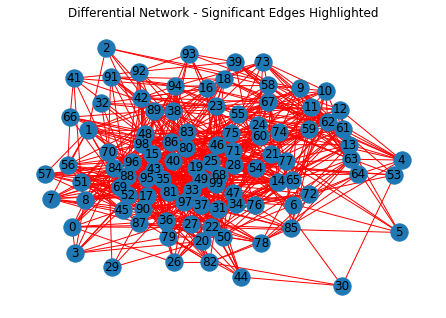

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to visualize the differential network
def visualize_differential_network(agg_adj_matrices, significant_edges):
    # Create the graph for visualization
    G = nx.Graph()
    
    # Add nodes and edges to the graph
    for label, agg_adj_matrix in agg_adj_matrices.items():
        num_nodes = agg_adj_matrix.shape[0]
        G.add_nodes_from(range(num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j:
                    # Add an edge if it's significant
                    if (i, j) in significant_edges or (j, i) in significant_edges:
                        G.add_edge(i, j, weight=agg_adj_matrix[i, j])
    
    # Draw the graph
    pos = nx.spring_layout(G)  # Positioning of the graph
    edge_colors = ['red' if (i, j) in significant_edges or (j, i) in significant_edges else 'black' for i, j in G.edges()]
    nx.draw(G, pos, edge_color=edge_colors, with_labels=True)
    plt.title('Differential Network - Significant Edges Highlighted')
    plt.show()

# Visualize the differential network
visualize_differential_network(agg_adj_matrices, significant_edges)


In [22]:
import networkx as nx

# Create a networkx graph from the significant edges
G_sig = nx.Graph()
G_sig.add_edges_from(significant_edges.keys())  # Assuming significant_edges is a dictionary with edges as keys

# Calculate network properties
density = nx.density(G_sig)
clustering_coefficient = nx.average_clustering(G_sig)
average_path_length = nx.average_shortest_path_length(G_sig)
modularity = nx.algorithms.community.quality.modularity(G_sig, nx.algorithms.community.greedy_modularity_communities(G_sig))

print(f"Density: {density}")
print(f"Clustering Coefficient: {clustering_coefficient}")
print(f"Average Path Length: {average_path_length}")
print(f"Modularity: {modularity}")

Density: 0.16404040404040404
Clustering Coefficient: 0.21778765292164828
Average Path Length: 1.961010101010101
Modularity: 0.2138056917178287


In [23]:
# Calculating node importance
node_importance = nx.betweenness_centrality(G_sig)

# Sorting nodes by importance
sorted_nodes = sorted(node_importance.items(), key=lambda item: item[1], reverse=True)
print("Nodes sorted by betweenness centrality:", sorted_nodes)


Nodes sorted by betweenness centrality: [(35, 0.03187893853366478), (31, 0.03037864539341184), (25, 0.028994068346027416), (40, 0.02859594950158834), (49, 0.026956111179602397), (99, 0.02178276122983597), (15, 0.020048684902352554), (90, 0.018907966465826667), (43, 0.01790876543717235), (48, 0.017767607907054377), (52, 0.017066085774874146), (95, 0.016631871906602192), (14, 0.015390516655860222), (19, 0.015129998300348162), (47, 0.014977565072530633), (46, 0.01497394431658438), (80, 0.014934219002789503), (83, 0.014909664544052464), (75, 0.01484301074914195), (51, 0.014727945785367007), (97, 0.01470335366505769), (70, 0.014583514802662668), (71, 0.014309317122027602), (65, 0.014280755156246496), (96, 0.01422064239458646), (54, 0.013973603348955076), (63, 0.013589557221867698), (59, 0.013417606882620302), (74, 0.013414664964084416), (60, 0.013048853573837154), (68, 0.01247473457235417), (88, 0.012384270100279583), (28, 0.012017990692200496), (77, 0.011205299309985784), (67, 0.0110645441

In [24]:
# Calculate edge betweenness centrality
edge_importance = nx.edge_betweenness_centrality(G_sig)

# Sorting edges by importance
sorted_edges = sorted(edge_importance.items(), key=lambda item: item[1], reverse=True)
print("Edges sorted by betweenness centrality:", sorted_edges)


Edges sorted by betweenness centrality: [((30, 54), 0.0076249192054608905), ((25, 29), 0.0069494141299792575), ((25, 53), 0.006023504932993681), ((90, 29), 0.005980440268365964), ((49, 32), 0.005686188627308807), ((5, 99), 0.005573942611970088), ((30, 82), 0.0052468930283664506), ((2, 48), 0.005166225594143552), ((40, 61), 0.0051515859928799495), ((74, 4), 0.005009521413845841), ((15, 64), 0.004812925043211307), ((6, 35), 0.004773625422987099), ((4, 30), 0.004715135036968041), ((64, 68), 0.004683488187651776), ((2, 25), 0.004662231491872502), ((31, 13), 0.004640746450704869), ((28, 53), 0.004586589863771677), ((51, 41), 0.004547309221766085), ((78, 35), 0.004523531352284205), ((31, 63), 0.00450976011616105), ((35, 93), 0.00449727978027808), ((74, 53), 0.004491746757805156), ((48, 66), 0.004489623918579061), ((34, 41), 0.0044515294034910904), ((30, 44), 0.00434757322666438), ((90, 32), 0.004312043010119938), ((96, 58), 0.004267895020137612), ((62, 49), 0.004146817057241646), ((70, 29), 

In [25]:
import networkx as nx
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
import dgl

from tqdm import tqdm

def compute_centrality_for_labels(graphs, labels, centrality_type):
    # Store the centrality values for each label
    centrality_values = defaultdict(lambda: defaultdict(list))

    for graph, label in tqdm(zip(graphs, labels), total=len(graphs), desc=f'Computing {centrality_type} centrality'):
        # Convert to networkx graph and then to simple graph with averaged edge weights
        nx_multigraph = dgl.to_networkx(graph).to_undirected()
        nx_graph = nx.Graph()
        for u, v, data in nx_multigraph.edges(data=True):
            w = data['weight'] if 'weight' in data else 1.0
            if nx_graph.has_edge(u, v):
                nx_graph[u][v]['weight'] += w
                nx_graph[u][v]['count'] += 1
            else:
                nx_graph.add_edge(u, v, weight=w, count=1)

        # Average the weights and remove self-loops
        for u, v, data in nx_graph.edges(data=True):
            data['weight'] /= data['count']
        nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))

        # Calculate centrality
        if centrality_type == 'betweenness':
            centrality = nx.betweenness_centrality(nx_graph, weight='weight')
        elif centrality_type == 'eigenvector':
            centrality = nx.eigenvector_centrality(nx_graph, weight='weight', max_iter=1000, tol=1e-06)
        else:
            raise ValueError("Invalid centrality type. Choose 'betweenness' or 'eigenvector'.")

        # Store the centrality values
        for node, value in centrality.items():
            centrality_values[label][node].append(value)

    return centrality_values



def analyze_differential_centrality(graphs, labels):
    # Compute centrality for each type and label
    betweenness_centrality_values = compute_centrality_for_labels(graphs, labels, 'betweenness')
    eigenvector_centrality_values = compute_centrality_for_labels(graphs, labels, 'eigenvector')

    # Analyze differences
    results = {}
    for centrality_type, centrality_data in [('betweenness', betweenness_centrality_values),
                                             ('eigenvector', eigenvector_centrality_values)]:
        differences = []
        p_values = []

        # Use tqdm to show progress
        nodes_list = list(centrality_data[0].keys())
        for node in tqdm(nodes_list, desc=f'Analyzing {centrality_type} centrality differences'):
            # Get the centrality values for each label
            values_label_0 = centrality_data[0][node]
            values_label_1 = centrality_data[1][node]
            
            # Calculate the mean difference
            mean_diff = np.mean(values_label_1) - np.mean(values_label_0)
            differences.append((node, mean_diff))
            
            # Perform t-test
            t_stat, p_value = ttest_ind(values_label_0, values_label_1, equal_var=False)
            p_values.append((node, p_value))

        # Sort based on the absolute mean difference
        differences.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Adjust p-values for multiple comparisons using Bonferroni correction
        adjusted_p_values = [(node, min(p * len(p_values), 1.0)) for node, p in p_values]  # Ensure p-values are capped at 1
        
        # Store the sorted differences and adjusted p-values in the results
        results[centrality_type] = {
            'differences': differences,
            'p_values': adjusted_p_values
        }
    
    return results

# Replace 'graphs' and 'labels' with your actual data
# This is just an example, replace with your actual lists of graphs and labels
graphs = [Abide100[i][0] for i in range(len(Abide100))]
labels = [Abide100[i][1] for i in range(len(Abide100))]

# Run the analysis
differential_results = analyze_differential_centrality(graphs, labels)

# Output the results
for centrality_type, data in differential_results.items():
    print(f"\n{centrality_type.capitalize()} Centrality:")
    print("Node, Mean Difference, Adjusted P-Value")
    for diff, p_val in zip(data['differences'], data['p_values']):
        node, mean_diff = diff
        node_p, adj_p_value = p_val
        # Print only significant results
        if adj_p_value < 0.10:
            print(f"Node {node}: {mean_diff:.4f}, {adj_p_value:.4g}")

Analyzing eigenvector centrality differences: 100%|██████████| 100/100 [00:00<00:00, 2673.17it/s]


Betweenness Centrality:
Node, Mean Difference, Adjusted P-Value
Node 25: -0.0010, 0.05372

Eigenvector Centrality:
Node, Mean Difference, Adjusted P-Value
Node 0: 0.0064, 0.0005444
Node 1: -0.0063, 0.007496
Node 56: -0.0018, 0.03164
Node 97: 0.0001, 0.006205


In [26]:
# Output the results
for centrality_type, data in differential_results.items():
    print(f"\n{centrality_type.capitalize()} Centrality:")
    print("Node, Mean Difference, Adjusted P-Value")
    for diff, p_val in zip(data['differences'], data['p_values']):
        node, mean_diff = diff
        node_p, adj_p_value = p_val
        # Print only significant results
        if adj_p_value < 0.054:
            print(f"Node {node}: {mean_diff:.4f}, {adj_p_value:.4g}")


Betweenness Centrality:
Node, Mean Difference, Adjusted P-Value
Node 25: -0.0010, 0.05372

Eigenvector Centrality:
Node, Mean Difference, Adjusted P-Value
Node 0: 0.0064, 0.0005444
Node 1: -0.0063, 0.007496
Node 56: -0.0018, 0.03164
Node 97: 0.0001, 0.006205


## Machine Learning Models

## Support Vector Machine (SVM)

#### Centrality Measurements

In [73]:
import networkx as nx
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
import dgl
from tqdm import tqdm
import networkx as nx
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
import dgl
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import pandas as pd


# Function to convert DGL graph to simplified NetworkX graph
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph


def compute_centrality_for_labels(graphs, labels, centrality_type):
    """Computes centrality values for each graph, organized by labels."""
    centrality_values = defaultdict(list)
    for graph, label in zip(graphs, labels):
        nx_graph = to_simple_graph(graph)
        if centrality_type == 'leverage':
            centrality = compute_leverage_centrality(nx_graph)
        else:
            centrality_method = getattr(nx, f"{centrality_type}_centrality", None)
            if centrality_method:
                centrality = centrality_method(nx_graph, weight='weight')
            else:
                raise ValueError(f"Centrality type {centrality_type} is not supported.")
        for _, value in centrality.items():
            centrality_values[label].append(value)
    return centrality_values

def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

def compute_edge_importance(graphs, labels, centrality_type):
    edge_importance = defaultdict(lambda: defaultdict(list))
    print(f"Computing edge importance for {centrality_type}:")
    for graph, label in tqdm(zip(graphs, labels), total=len(graphs), desc=f'Progress'):
        nx_graph = to_simple_graph(graph)
        centrality = None
        if centrality_type == 'leverage':
            centrality = compute_leverage_centrality(nx_graph)
        else:
            centrality_function = getattr(nx, f'{centrality_type}_centrality', None)
            if centrality_function is None:
                raise ValueError(f"Centrality type '{centrality_type}' not supported.")
            # Check if centrality function supports the 'weight' parameter
            supported_params = centrality_function.__code__.co_varnames
            if 'weight' in supported_params:
                centrality = centrality_function(nx_graph, weight='weight')
            else:
                centrality = centrality_function(nx_graph)
        for u, v in nx_graph.edges():
            edge_importance[(u, v)][label].append(centrality[u] + centrality[v])
    return edge_importance



def analyze_differential_edge_importance(edge_importance, centrality_type):
    significant_edges = []
    for edge, label_importances in edge_importance.items():
        if len(label_importances.keys()) > 1:
            values_0 = label_importances[0]
            values_1 = label_importances[1]
            mean_diff = np.mean(values_1) - np.mean(values_0)
            _, p_value = ttest_ind(values_0, values_1)
            if p_value < 0.03:  # Using unadjusted p-value for demonstration
                significant_edges.append((centrality_type, edge, mean_diff, p_value))
    return significant_edges

def compute_node_importance(graphs, labels, centrality_type):
    node_importance = defaultdict(lambda: defaultdict(list))
    for graph, label in tqdm(zip(graphs, labels), total=len(graphs), desc=f'Computing node importance for {centrality_type}'):
        nx_graph = to_simple_graph(graph)
        centrality = None
        if centrality_type == 'leverage':
            centrality = compute_leverage_centrality(nx_graph)
        else:
            centrality_function = getattr(nx, f'{centrality_type}_centrality', None)
            if centrality_function is None:
                raise ValueError(f"Centrality type '{centrality_type}' not supported.")
            # Check if centrality function supports the 'weight' parameter
            supported_params = centrality_function.__code__.co_varnames
            if 'weight' in supported_params:
                centrality = centrality_function(nx_graph, weight='weight')
            else:
                centrality = centrality_function(nx_graph)
        for node, value in centrality.items():
            node_importance[node][label].append(value)
    return node_importance

# Function to analyze differential node importance
def analyze_differential_node_importance(node_importance, centrality_type):
    significant_nodes = []
    p_values = []
    node_info = []
    
    for node, label_importances in node_importance.items():
        if len(label_importances) > 1:
            values_0 = label_importances[0]
            values_1 = label_importances[1]
            mean_diff = np.mean(values_1) - np.mean(values_0)
            _, p_value = ttest_ind(values_0, values_1, nan_policy='omit')
            if p_value < 0.03:
                p_values.append(p_value)
                node_info.append((node, mean_diff))
    
    # Apply multiple test correction
    _, adj_p_values, _, _ = multipletests(p_values, alpha=0.1, method='fdr_bh')
    
    # Populate significant_nodes with adjusted p-values
    for (node, mean_diff), adj_p_value in zip(node_info, adj_p_values):
        significant_nodes.append((centrality_type, node, mean_diff, adj_p_value))
    
    return significant_nodes


# Function to analyze differential centrality
def analyze_differential_centrality(graphs, labels):
    centrality_types = ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector']
    differential_results = defaultdict(list)
    for centrality_type in centrality_types:
        if centrality_type != 'leverage':
            node_importance = compute_node_importance(graphs, labels, centrality_type)
            significant_nodes = analyze_differential_node_importance(node_importance, centrality_type)
            differential_results[centrality_type].extend(significant_nodes)

    return differential_results


# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

print("\n=========================================================================")
print("=========================================================================\n")


# Collecting all significant edges data for DataFrame creation
all_significant_edges = []

for centrality_type in ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector']:
    edge_importance = compute_edge_importance(graphs, labels, centrality_type)
    # Pass centrality_type as the second argument to the function
    significant_edges = analyze_differential_edge_importance(edge_importance, centrality_type)
    for centrality, edge, diff, p in significant_edges:
        all_significant_edges.append({
            'Centrality': centrality,
            'Edge Pairs': edge,
            'Mean Difference': diff,
            'P-Value': p
        })

# Create DataFrame for significant edges
df_edges = pd.DataFrame(all_significant_edges, columns=['Centrality', 'Edge Pairs', 'Mean Difference', 'P-Value'])
df_edges.to_csv('significant_edges.csv', index=False)

# Collecting all significant nodes data from differential_results for DataFrame creation
all_significant_nodes = []
for centrality_type, significant_differences in differential_results.items():
    for centrality, node, mean_diff, adj_p_value in significant_differences:
        all_significant_nodes.append({
            'Centrality': centrality,
            'Node': node,
            'Mean Difference': mean_diff,
            'Adjusted P-Value': adj_p_value
        })

# Create DataFrame for significant nodes
df_nodes = pd.DataFrame(all_significant_nodes)
df_nodes.to_csv('significant_nodes.csv', index=False)

  3%|▎         | 30/1025 [00:00<00:03, 297.33it/s]

[!] Dataset:  Abide100Dataset
[]


Progress:   0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 3.0289s


Computing edge importance for closeness:


Progress: 100%|██████████| 1025/1025 [00:39<00:00, 26.11it/s]
/home/marcus/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/marcus/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Progress:   1%|          | 7/1025 [00:00<00:16, 61.53it/s]

Computing edge importance for leverage:


Progress:   0%|          | 1/1025 [00:00<01:55,  8.88it/s]

Computing edge importance for betweenness:


Progress:   1%|          | 7/1025 [00:00<00:16, 61.80it/s]

Computing edge importance for degree:


Progress:   0%|          | 5/1025 [00:00<00:25, 40.66it/s]

Computing edge importance for eigenvector:


Progress: 100%|██████████| 1025/1025 [00:38<00:00, 26.45it/s]


"# Collecting all significant nodes data from differential_results for DataFrame creation\nall_significant_nodes = []\nfor centrality_type, significant_differences in differential_results.items():\n    for centrality, node, mean_diff, adj_p_value in significant_differences:\n        all_significant_nodes.append({\n            'Centrality': centrality,\n            'Node': node,\n            'Mean Difference': mean_diff,\n            'Adjusted P-Value': adj_p_value\n        })\n\n# Create DataFrame for significant nodes\ndf_nodes = pd.DataFrame(all_significant_nodes)\ndf_nodes.to_csv('significant_nodes.csv', index=False)"

In [74]:
df_nodes

,Centrality,Node,Mean Difference,Adjusted P-Value
0,closeness,31,0.013347,0.007133
1,closeness,35,0.009727,0.010888
2,closeness,37,-0.010394,0.034216
3,closeness,38,-0.008328,0.042575
4,closeness,71,-0.006586,0.038033
...,...,...,...,...
85,eigenvector,28,0.006759,0.028552
86,eigenvector,25,-0.004874,0.043367
87,eigenvector,60,-0.004799,0.043367
88,eigenvector,43,-0.006165,0.028552


In [75]:
df_edges

,Centrality,Edge Pairs,Mean Difference,P-Value
0,closeness,"(0, 31)",0.025572,0.011556
1,closeness,"(0, 91)",0.034268,0.001345
2,closeness,"(2, 7)",-0.017237,0.008086
3,closeness,"(2, 9)",-0.037754,0.001614
4,closeness,"(2, 61)",-0.032613,0.011339
...,...,...,...,...
3723,eigenvector,"(67, 1)",-0.073285,0.009080
3724,eigenvector,"(6, 2)",-0.047191,0.036377
3725,eigenvector,"(25, 2)",0.035634,0.023423
3726,eigenvector,"(71, 51)",-0.048877,0.010733


In [36]:
df_edges.to_csv('significant_edges.csv', index=False)
df_nodes.to_csv('significant_nodes.csv', index=False)

### SVM with significant nodes and edges (different features)

##### SVM with features: Mean Difference

  3%|▎         | 30/1025 [00:00<00:03, 295.19it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 420.07it/s]


Time taken: 3.1521s
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'C': 1.6, 'gamma': 'auto', 'kernel': 'poly'}
Accuracy: 0.551219512195122
              precision    recall  f1-score   support

           0       0.55      0.88      0.67       108
           1       0.58      0.19      0.28        97

    accuracy                           0.55       205
   macro avg       0.56      0.53      0.48       205
weighted avg       0.56      0.55      0.49       205



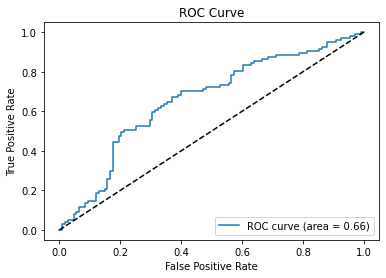

In [50]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the SVM model
param_grid = {
    'C': [0.1, 1, 1.4, 1.5, 1.6],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001 ],
    'kernel': ['rbf', 'linear', 'poly']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
fpr, tpr, _ = roc_curve(y_test, grid_search.decision_function(X_test_scaled))
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [76]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

centralities = ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector']

param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

centrality_significance = compute_centrality_significance(df_nodes, df_edges)
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

grid_search = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, verbose=2)

def get_data_for_centralities(df_nodes, df_edges, centralities):
    filtered_nodes = df_nodes[df_nodes['Centrality'].isin(centralities)]
    filtered_edges = df_edges[df_edges['Centrality'].isin(centralities)]
    return filtered_nodes, filtered_edges

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)

def run_svm_for_centralities(graphs, labels, centralities, data_type):
    filtered_nodes, filtered_edges = get_data_for_centralities(df_nodes, df_edges, centralities)
    X = extract_enhanced_features(graphs, filtered_nodes, filtered_edges, global_median_node, global_median_edge, centrality_significance)
    y = np.array(labels)
    
    if X.size == 0:
        print(f"No features extracted for centralities: {centralities} ({data_type}-based). Skipping...")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    grid_search.fit(X_train_scaled, y_train)
    accuracy = accuracy_score(y_test, grid_search.predict(X_test_scaled))
    roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
    
    print(f"Permutation: {centralities} ({data_type}-based), Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, Best Params: {grid_search.best_params_}")
    return accuracy, roc_auc, grid_search.best_params_

results = {}
data_types = ['Node', 'Edge', 'Both']
for data_type in data_types:
    for r in tqdm(range(1, len(centralities) + 1), desc='Overall Progress'):
        for combo in tqdm(itertools.combinations(centralities, r), desc='Processing centrality combinations'):
            accuracy, roc_auc, best_params = run_svm_for_centralities(graphs, labels, list(combo), data_type)
            if accuracy is not None:  # Ensure we only save results for successful runs
                results[(combo, data_type)] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'best_params': best_params}

# Print the best-performing combination
best_combo = max(results, key=lambda k: results[k]['roc_auc'])
print(f"Best Combination: {best_combo}, Metrics: {results[best_combo]}")

  3%|▎         | 35/1025 [00:00<00:02, 348.25it/s]

[!] Dataset:  Abide100Dataset
[]


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Time taken: 3.3490s
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness'] (Node-based), Accuracy: 0.5463, ROC AUC: 0.6649, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage'] (Node-based), Accuracy: 0.5122, ROC AUC: 0.6662, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6528, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['degree'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6626, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 5it [04:29, 53.89s/it]
Overall Progress:  20%|██        | 1/5 [04:29<17:57, 269.46s/it]

Permutation: ['eigenvector'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6585, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6718, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6709, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'degree'] (Node-based), Accuracy: 0.5463, ROC AUC: 0.6666, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6649, Best Params: {'C': 5, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness'] (Node-based), Accuracy: 0.5171, ROC AUC: 0.6677, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'degree'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6771, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'eigenvector'] (Node-based), Accuracy: 0.6293, ROC AUC: 0.6722, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness', 'degree'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6782, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6713, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 10it [12:12, 73.27s/it]
Overall Progress:  40%|████      | 2/5 [16:42<27:05, 541.98s/it]

Permutation: ['degree', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6599, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6691, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'degree'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6741, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6786, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6777, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6731, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6625, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6734, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6774, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6733, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 10it [14:17, 85.74s/it]
Overall Progress:  60%|██████    | 3/5 [30:59<22:51, 685.99s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6705, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6759, Best Params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.6293, ROC AUC: 0.6803, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6722, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5463, ROC AUC: 0.6719, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 5it [07:55, 95.00s/it]
Overall Progress:  80%|████████  | 4/5 [38:54<10:02, 602.70s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6689, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 1it [01:42, 102.06s/it]
Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.6293, ROC AUC: 0.6813, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness'] (Edge-based), Accuracy: 0.5463, ROC AUC: 0.6649, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage'] (Edge-based), Accuracy: 0.5122, ROC AUC: 0.6662, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6528, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['degree'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6626, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 5it [04:27, 53.57s/it]
Overall Progress:  20%|██        | 1/5 [04:27<17:51, 267.87s/it]

Permutation: ['eigenvector'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6585, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6718, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6709, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'degree'] (Edge-based), Accuracy: 0.5463, ROC AUC: 0.6666, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6649, Best Params: {'C': 5, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness'] (Edge-based), Accuracy: 0.5171, ROC AUC: 0.6677, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'degree'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6771, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'eigenvector'] (Edge-based), Accuracy: 0.6293, ROC AUC: 0.6722, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness', 'degree'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6782, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6713, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 10it [12:12, 73.20s/it]
Overall Progress:  40%|████      | 2/5 [16:39<27:02, 540.91s/it]

Permutation: ['degree', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6599, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6691, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'degree'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6741, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6786, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6777, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6731, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6625, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6734, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6774, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6733, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 10it [14:14, 85.46s/it]
Overall Progress:  60%|██████    | 3/5 [30:54<22:48, 684.15s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6705, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6759, Best Params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.6293, ROC AUC: 0.6803, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6722, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5463, ROC AUC: 0.6719, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 5it [07:53, 94.70s/it]
Overall Progress:  80%|████████  | 4/5 [38:48<10:00, 600.98s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6689, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 1it [01:42, 102.35s/it]
Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.6293, ROC AUC: 0.6813, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness'] (Both-based), Accuracy: 0.5463, ROC AUC: 0.6649, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage'] (Both-based), Accuracy: 0.5122, ROC AUC: 0.6662, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6528, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['degree'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6626, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 5it [04:28, 53.62s/it]
Overall Progress:  20%|██        | 1/5 [04:28<17:52, 268.12s/it]

Permutation: ['eigenvector'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6585, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6718, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6709, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'degree'] (Both-based), Accuracy: 0.5463, ROC AUC: 0.6666, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6649, Best Params: {'C': 5, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness'] (Both-based), Accuracy: 0.5171, ROC AUC: 0.6677, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'degree'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6771, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'eigenvector'] (Both-based), Accuracy: 0.6293, ROC AUC: 0.6722, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness', 'degree'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6782, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6713, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 10it [12:12, 73.26s/it]
Overall Progress:  40%|████      | 2/5 [16:40<27:04, 541.35s/it]

Permutation: ['degree', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6599, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6691, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'degree'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6741, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6786, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6777, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6731, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6625, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6734, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6774, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6733, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 10it [14:14, 85.45s/it]
Overall Progress:  60%|██████    | 3/5 [30:55<22:48, 684.34s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6705, Best Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6759, Best Params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.6293, ROC AUC: 0.6803, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6722, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5463, ROC AUC: 0.6719, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 5it [07:53, 94.80s/it]
Overall Progress:  80%|████████  | 4/5 [38:49<10:01, 601.29s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6689, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


Processing centrality combinations: 1it [01:42, 102.52s/it]
Overall Progress: 100%|██████████| 5/5 [40:31<00:00, 486.35s/it]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.6293, ROC AUC: 0.6813, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Best Combination: (('closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'), 'Node'), Metrics: {'accuracy': 0.6292682926829268, 'roc_auc': 0.6812714776632303, 'best_params': {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}}


##### Nodes 0.04, Edges 0.03

In [77]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes_040.csv')
df_edges = pd.read_csv('significant_edges_030.csv')

centralities = ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector']

param_grid = {
    'C': [0.1, 0.5, 1, 2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

centrality_significance = compute_centrality_significance(df_nodes, df_edges)
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

grid_search = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(10), scoring='roc_auc', n_jobs=-1, verbose=2)

def get_data_for_centralities(df_nodes, df_edges, centralities):
    filtered_nodes = df_nodes[df_nodes['Centrality'].isin(centralities)]
    filtered_edges = df_edges[df_edges['Centrality'].isin(centralities)]
    return filtered_nodes, filtered_edges

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)

def run_svm_for_centralities(graphs, labels, centralities, data_type):
    filtered_nodes, filtered_edges = get_data_for_centralities(df_nodes, df_edges, centralities)
    X = extract_enhanced_features(graphs, filtered_nodes, filtered_edges, global_median_node, global_median_edge, centrality_significance)
    y = np.array(labels)
    
    if X.size == 0:
        print(f"No features extracted for centralities: {centralities} ({data_type}-based). Skipping...")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    grid_search.fit(X_train_scaled, y_train)
    accuracy = accuracy_score(y_test, grid_search.predict(X_test_scaled))
    roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
    
    print(f"Permutation: {centralities} ({data_type}-based), Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, Best Params: {grid_search.best_params_}")
    return accuracy, roc_auc, grid_search.best_params_

results = {}
data_types = ['Node', 'Edge', 'Both']
for data_type in data_types:
    for r in tqdm(range(1, len(centralities) + 1), desc='Overall Progress'):
        for combo in tqdm(itertools.combinations(centralities, r), desc='Processing centrality combinations'):
            accuracy, roc_auc, best_params = run_svm_for_centralities(graphs, labels, list(combo), data_type)
            if accuracy is not None:  # Ensure we only save results for successful runs
                results[(combo, data_type)] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'best_params': best_params}

# Print the best-performing combination
best_combo = max(results, key=lambda k: results[k]['roc_auc'])
print(f"Best Combination: {best_combo}, Metrics: {results[best_combo]}")

  3%|▎         | 35/1025 [00:00<00:02, 346.43it/s]

[!] Dataset:  Abide100Dataset
[]


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Time taken: 3.0324s
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6768, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6447, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6234, Best Params: {'C': 3, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['degree'] (Node-based), Accuracy: 0.5805, ROC AUC: 0.6703, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [05:23, 64.61s/it]
Overall Progress:  20%|██        | 1/5 [05:23<21:32, 323.08s/it]

Permutation: ['eigenvector'] (Node-based), Accuracy: 0.5463, ROC AUC: 0.6490, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6664, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness'] (Node-based), Accuracy: 0.5463, ROC AUC: 0.6743, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6865, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6769, Best Params: {'C': 0.5, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6569, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6730, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'eigenvector'] (Node-based), Accuracy: 0.5171, ROC AUC: 0.6693, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'degree'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6682, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6583, Best Params: {'C': 4, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [15:36, 93.67s/it]
Overall Progress:  40%|████      | 2/5 [20:59<34:12, 684.04s/it]

Permutation: ['degree', 'eigenvector'] (Node-based), Accuracy: 0.5561, ROC AUC: 0.6580, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6691, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6798, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6797, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6805, Best Params: {'C': 2, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5463, ROC AUC: 0.6739, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6694, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6613, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6580, Best Params: {'C': 2, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6695, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [18:57, 113.74s/it]
Overall Progress:  60%|██████    | 3/5 [39:57<29:42, 891.06s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5512, ROC AUC: 0.6645, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6709, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6677, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6839, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6724, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [10:42, 128.40s/it]
Overall Progress:  80%|████████  | 4/5 [50:39<13:12, 792.74s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6583, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 1it [02:19, 139.69s/it]
Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6683, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6768, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6447, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6234, Best Params: {'C': 3, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['degree'] (Edge-based), Accuracy: 0.5805, ROC AUC: 0.6703, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [05:21, 64.32s/it]
Overall Progress:  20%|██        | 1/5 [05:21<21:26, 321.58s/it]

Permutation: ['eigenvector'] (Edge-based), Accuracy: 0.5463, ROC AUC: 0.6490, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6664, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness'] (Edge-based), Accuracy: 0.5463, ROC AUC: 0.6743, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6865, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6769, Best Params: {'C': 0.5, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6569, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6730, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'eigenvector'] (Edge-based), Accuracy: 0.5171, ROC AUC: 0.6693, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'degree'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6682, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6583, Best Params: {'C': 4, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [15:37, 93.78s/it]
Overall Progress:  40%|████      | 2/5 [20:59<34:12, 684.07s/it]

Permutation: ['degree', 'eigenvector'] (Edge-based), Accuracy: 0.5561, ROC AUC: 0.6580, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6691, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6798, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6797, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6805, Best Params: {'C': 2, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5463, ROC AUC: 0.6739, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6694, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6613, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6580, Best Params: {'C': 2, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6695, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [18:55, 113.58s/it]
Overall Progress:  60%|██████    | 3/5 [39:55<29:40, 890.36s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5512, ROC AUC: 0.6645, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6709, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6677, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6839, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6724, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [10:41, 128.25s/it]
Overall Progress:  80%|████████  | 4/5 [50:36<13:12, 792.01s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6583, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 1it [02:19, 139.57s/it]
Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6683, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6768, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6447, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6234, Best Params: {'C': 3, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['degree'] (Both-based), Accuracy: 0.5805, ROC AUC: 0.6703, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [05:21, 64.36s/it]
Overall Progress:  20%|██        | 1/5 [05:21<21:27, 321.82s/it]

Permutation: ['eigenvector'] (Both-based), Accuracy: 0.5463, ROC AUC: 0.6490, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6664, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness'] (Both-based), Accuracy: 0.5463, ROC AUC: 0.6743, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6865, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6769, Best Params: {'C': 0.5, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6569, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6730, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'eigenvector'] (Both-based), Accuracy: 0.5171, ROC AUC: 0.6693, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'degree'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6682, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6583, Best Params: {'C': 4, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [15:37, 93.74s/it]
Overall Progress:  40%|████      | 2/5 [20:59<34:11, 683.92s/it]

Permutation: ['degree', 'eigenvector'] (Both-based), Accuracy: 0.5561, ROC AUC: 0.6580, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6691, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6798, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6797, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6805, Best Params: {'C': 2, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5463, ROC AUC: 0.6739, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6694, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6613, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6580, Best Params: {'C': 2, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6695, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [18:48, 112.87s/it]
Overall Progress:  60%|██████    | 3/5 [39:47<29:34, 887.02s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5512, ROC AUC: 0.6645, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6709, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6677, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6839, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6724, Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [10:34, 126.86s/it]
Overall Progress:  80%|████████  | 4/5 [50:22<13:07, 787.24s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6583, Best Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 1it [02:17, 137.90s/it]
Overall Progress: 100%|██████████| 5/5 [52:40<00:00, 632.02s/it]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6683, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Best Combination: (('closeness', 'degree'), 'Node'), Metrics: {'accuracy': 0.5414634146341464, 'roc_auc': 0.6865215731195113, 'best_params': {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}}


##### Nodes 0.03, Edges 0.02

In [78]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes_030.csv')
df_edges = pd.read_csv('significant_edges_020.csv')

centralities = ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector']

param_grid = {
    'C': [0.1, 0.5, 1, 2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

centrality_significance = compute_centrality_significance(df_nodes, df_edges)
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

grid_search = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(10), scoring='roc_auc', n_jobs=-1, verbose=2)

def get_data_for_centralities(df_nodes, df_edges, centralities):
    filtered_nodes = df_nodes[df_nodes['Centrality'].isin(centralities)]
    filtered_edges = df_edges[df_edges['Centrality'].isin(centralities)]
    return filtered_nodes, filtered_edges

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)

def run_svm_for_centralities(graphs, labels, centralities, data_type):
    filtered_nodes, filtered_edges = get_data_for_centralities(df_nodes, df_edges, centralities)
    X = extract_enhanced_features(graphs, filtered_nodes, filtered_edges, global_median_node, global_median_edge, centrality_significance)
    y = np.array(labels)
    
    if X.size == 0:
        print(f"No features extracted for centralities: {centralities} ({data_type}-based). Skipping...")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    grid_search.fit(X_train_scaled, y_train)
    accuracy = accuracy_score(y_test, grid_search.predict(X_test_scaled))
    roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
    
    print(f"Permutation: {centralities} ({data_type}-based), Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, Best Params: {grid_search.best_params_}")
    return accuracy, roc_auc, grid_search.best_params_

results = {}
data_types = ['Node', 'Edge', 'Both']
for data_type in data_types:
    for r in tqdm(range(1, len(centralities) + 1), desc='Overall Progress'):
        for combo in tqdm(itertools.combinations(centralities, r), desc='Processing centrality combinations'):
            accuracy, roc_auc, best_params = run_svm_for_centralities(graphs, labels, list(combo), data_type)
            if accuracy is not None:  # Ensure we only save results for successful runs
                results[(combo, data_type)] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'best_params': best_params}

# Print the best-performing combination
best_combo = max(results, key=lambda k: results[k]['roc_auc'])
print(f"Best Combination: {best_combo}, Metrics: {results[best_combo]}")

  4%|▍         | 43/1025 [00:00<00:02, 423.02it/s]

[!] Dataset:  Abide100Dataset
[]


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Time taken: 2.8838s
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6674, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6276, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness'] (Node-based), Accuracy: 0.5805, ROC AUC: 0.6200, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['degree'] (Node-based), Accuracy: 0.5805, ROC AUC: 0.6453, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [10:25, 125.05s/it]
Overall Progress:  20%|██        | 1/5 [10:25<41:41, 625.27s/it]

Permutation: ['eigenvector'] (Node-based), Accuracy: 0.5415, ROC AUC: 0.6923, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6624, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6724, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6811, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6926, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6343, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6474, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'eigenvector'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6674, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'degree'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6564, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6778, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [11:19, 67.90s/it]
Overall Progress:  40%|████      | 2/5 [21:44<32:50, 656.89s/it]

Permutation: ['degree', 'eigenvector'] (Node-based), Accuracy: 0.5659, ROC AUC: 0.6754, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6690, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6653, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6795, Best Params: {'C': 4, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6713, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5512, ROC AUC: 0.6768, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6930, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6502, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6665, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6720, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [13:56, 83.69s/it]
Overall Progress:  60%|██████    | 3/5 [35:41<24:38, 739.08s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6641, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6682, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Node-based), Accuracy: 0.5268, ROC AUC: 0.6787, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5220, ROC AUC: 0.6797, Best Params: {'C': 4, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5366, ROC AUC: 0.6767, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [07:52, 94.50s/it]
Overall Progress:  80%|████████  | 4/5 [43:33<10:33, 633.83s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6712, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 1it [01:41, 101.83s/it]
Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Node-based), Accuracy: 0.5317, ROC AUC: 0.6715, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6674, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6276, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness'] (Edge-based), Accuracy: 0.5805, ROC AUC: 0.6200, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['degree'] (Edge-based), Accuracy: 0.5805, ROC AUC: 0.6453, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [10:26, 125.21s/it]
Overall Progress:  20%|██        | 1/5 [10:26<41:44, 626.07s/it]

Permutation: ['eigenvector'] (Edge-based), Accuracy: 0.5415, ROC AUC: 0.6923, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6624, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6724, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6811, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6926, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6343, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6474, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'eigenvector'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6674, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'degree'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6564, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6778, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [11:18, 67.86s/it]
Overall Progress:  40%|████      | 2/5 [21:44<32:50, 656.94s/it]

Permutation: ['degree', 'eigenvector'] (Edge-based), Accuracy: 0.5659, ROC AUC: 0.6754, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6690, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6653, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6795, Best Params: {'C': 4, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6713, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5512, ROC AUC: 0.6768, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6930, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6502, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6665, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6720, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [13:57, 83.73s/it]
Overall Progress:  60%|██████    | 3/5 [35:41<24:38, 739.30s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6641, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6682, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'eigenvector'] (Edge-based), Accuracy: 0.5268, ROC AUC: 0.6787, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5220, ROC AUC: 0.6797, Best Params: {'C': 4, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5366, ROC AUC: 0.6767, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [07:52, 94.52s/it]
Overall Progress:  80%|████████  | 4/5 [43:34<10:34, 634.00s/it]

Permutation: ['leverage', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6712, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 1it [01:42, 102.25s/it]
Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Permutation: ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector'] (Edge-based), Accuracy: 0.5317, ROC AUC: 0.6715, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6674, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6276, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness'] (Both-based), Accuracy: 0.5805, ROC AUC: 0.6200, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['degree'] (Both-based), Accuracy: 0.5805, ROC AUC: 0.6453, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 5it [10:25, 125.20s/it]
Overall Progress:  20%|██        | 1/5 [10:25<41:43, 625.99s/it]

Permutation: ['eigenvector'] (Both-based), Accuracy: 0.5415, ROC AUC: 0.6923, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6624, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6724, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6811, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6926, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6343, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6474, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'eigenvector'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6674, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'degree'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6564, Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6778, Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [11:19, 67.96s/it]
Overall Progress:  40%|████      | 2/5 [21:45<32:52, 657.50s/it]

Permutation: ['degree', 'eigenvector'] (Both-based), Accuracy: 0.5659, ROC AUC: 0.6754, Best Params: {'C': 3, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6690, Best Params: {'C': 4, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'degree'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6653, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'eigenvector'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6795, Best Params: {'C': 4, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6713, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5512, ROC AUC: 0.6768, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6930, Best Params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5317, ROC AUC: 0.6502, Best Params: {'C': 2, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'betweenness', 'eigenvector'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6665, Best Params: {'C': 5, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['leverage', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5220, ROC AUC: 0.6720, Best Params: {'C': 3, 'gamma': 'auto', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Processing centrality combinations: 10it [13:58, 83.86s/it]
Overall Progress:  60%|██████    | 3/5 [35:44<24:40, 740.20s/it]

Permutation: ['betweenness', 'degree', 'eigenvector'] (Both-based), Accuracy: 0.5366, ROC AUC: 0.6641, Best Params: {'C': 2, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


Permutation: ['closeness', 'leverage', 'betweenness', 'degree'] (Both-based), Accuracy: 0.5268, ROC AUC: 0.6682, Best Params: {'C': 3, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 10 folds for each of 126 candidates, totalling 1260 fits


##### Nodes 0.02, Edges 0.01

In [ ]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes_020.csv')
df_edges = pd.read_csv('significant_edges_010.csv')

centralities = ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector']

param_grid = {
    'C': [0.1, 0.5, 1, 2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

centrality_significance = compute_centrality_significance(df_nodes, df_edges)
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

grid_search = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(10), scoring='roc_auc', n_jobs=-1, verbose=2)

def get_data_for_centralities(df_nodes, df_edges, centralities):
    filtered_nodes = df_nodes[df_nodes['Centrality'].isin(centralities)]
    filtered_edges = df_edges[df_edges['Centrality'].isin(centralities)]
    return filtered_nodes, filtered_edges

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)

def run_svm_for_centralities(graphs, labels, centralities, data_type):
    filtered_nodes, filtered_edges = get_data_for_centralities(df_nodes, df_edges, centralities)
    X = extract_enhanced_features(graphs, filtered_nodes, filtered_edges, global_median_node, global_median_edge, centrality_significance)
    y = np.array(labels)
    
    if X.size == 0:
        print(f"No features extracted for centralities: {centralities} ({data_type}-based). Skipping...")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    grid_search.fit(X_train_scaled, y_train)
    accuracy = accuracy_score(y_test, grid_search.predict(X_test_scaled))
    roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
    
    print(f"Permutation: {centralities} ({data_type}-based), Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, Best Params: {grid_search.best_params_}")
    return accuracy, roc_auc, grid_search.best_params_

results = {}
data_types = ['Node', 'Edge', 'Both']
for data_type in data_types:
    for r in tqdm(range(1, len(centralities) + 1), desc='Overall Progress'):
        for combo in tqdm(itertools.combinations(centralities, r), desc='Processing centrality combinations'):
            accuracy, roc_auc, best_params = run_svm_for_centralities(graphs, labels, list(combo), data_type)
            if accuracy is not None:  # Ensure we only save results for successful runs
                results[(combo, data_type)] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'best_params': best_params}

# Print the best-performing combination
best_combo = max(results, key=lambda k: results[k]['roc_auc'])
print(f"Best Combination: {best_combo}, Metrics: {results[best_combo]}")

##### Nodes Top 10 Nodes, Edges Top 100 Edges

In [ ]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes_top10nodes.csv')
df_edges = pd.read_csv('significant_edges_top10edges.csv')

centralities = ['closeness', 'leverage', 'betweenness', 'degree', 'eigenvector']

param_grid = {
    'C': [0.1, 0.5, 1, 2, 3, 4, 5],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

centrality_significance = compute_centrality_significance(df_nodes, df_edges)
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

grid_search = GridSearchCV(SVC(), param_grid, cv=StratifiedKFold(10), scoring='roc_auc', n_jobs=-1, verbose=2)

def get_data_for_centralities(df_nodes, df_edges, centralities):
    filtered_nodes = df_nodes[df_nodes['Centrality'].isin(centralities)]
    filtered_edges = df_edges[df_edges['Centrality'].isin(centralities)]
    return filtered_nodes, filtered_edges

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)

def run_svm_for_centralities(graphs, labels, centralities, data_type):
    filtered_nodes, filtered_edges = get_data_for_centralities(df_nodes, df_edges, centralities)
    X = extract_enhanced_features(graphs, filtered_nodes, filtered_edges, global_median_node, global_median_edge, centrality_significance)
    y = np.array(labels)
    
    if X.size == 0:
        print(f"No features extracted for centralities: {centralities} ({data_type}-based). Skipping...")
        return None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    grid_search.fit(X_train_scaled, y_train)
    accuracy = accuracy_score(y_test, grid_search.predict(X_test_scaled))
    roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
    
    print(f"Permutation: {centralities} ({data_type}-based), Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, Best Params: {grid_search.best_params_}")
    return accuracy, roc_auc, grid_search.best_params_

results = {}
data_types = ['Node', 'Edge', 'Both']
for data_type in data_types:
    for r in tqdm(range(1, len(centralities) + 1), desc='Overall Progress'):
        for combo in tqdm(itertools.combinations(centralities, r), desc='Processing centrality combinations'):
            accuracy, roc_auc, best_params = run_svm_for_centralities(graphs, labels, list(combo), data_type)
            if accuracy is not None:  # Ensure we only save results for successful runs
                results[(combo, data_type)] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'best_params': best_params}

# Print the best-performing combination
best_combo = max(results, key=lambda k: results[k]['roc_auc'])
print(f"Best Combination: {best_combo}, Metrics: {results[best_combo]}")

#### SVM ATM

In [ ]:
!pip install atm

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import dgl

# Assuming DGL and NetworkX are used for graph manipulation

def to_simple_graph(dgl_graph):
    """Convert DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default to 1.0 if missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    """Transform p-value for feature scaling."""
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    """Compute significance score for centrality measures."""
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    """Aggregate node data for centrality features."""
    return df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()

def extract_graph_features(graph, df_nodes, df_edges, centrality_significance):
    """Extract combined graph and centrality features."""
    nx_graph = to_simple_graph(graph)
    features = []

    # Node-based features
    for node in nx_graph.nodes():
        node_data = df_nodes.loc[df_nodes['Node'] == node]
        if not node_data.empty:
            mean_diff = node_data['Mean Difference'].values[0] * centrality_significance.get(node, 1)
            p_val = node_data['Adjusted P-Value'].values[0]
            features.append(mean_diff * transform_p_value(p_val))

    # Edge-based features
    for u, v in nx_graph.edges():
        edge_tuple = str((u, v))  # Convert edge to string to match keys
        edge_data = df_edges.loc[df_edges['Edge Pairs'].apply(ast.literal_eval) == edge_tuple]
        if not edge_data.empty:
            mean_diff = edge_data['Mean Difference'].values[0] * centrality_significance.get(edge_tuple, 1)
            p_val = edge_data['P-Value'].values[0]
            features.append(mean_diff * transform_p_value(p_val))

    return features

# Load data (graphs and labels)
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Load centrality data
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Feature extraction
feature_matrix = []
for graph in tqdm(graphs, desc='Extracting features'):
    features = extract_graph_features(graph, df_nodes, df_edges, centrality_significance)
    feature_matrix.append(features)

# Prepare the dataset
df_features = pd.DataFrame(feature_matrix)
df_features['label'] = labels  # Add labels column
df_features.to_csv('graph_features.csv', index=False)  # Save to CSV

print("Feature extraction and dataset preparation complete.")

In [ ]:
from atm import ATM
from atm.config import DataConfig

# Assuming ATM and necessary imports are correctly set up

# Define the path to your prepared CSV file
dataset_path = 'graph_features.csv'

# Define the name of the target variable column in your dataset
target_column = 'label'

# Create a DataConfig object with your dataset information
data_config = DataConfig(
    train_path=dataset_path,
    class_column=target_column,
)

# Initialize an ATM object
atm = ATM()

# Run ATM with your dataset
# Note: You can customize the run configuration (RunConfig) and the database configuration (SQLConfig) as needed.
datarun_id = atm.run(data_config=data_config)

# After the run is complete, retrieve details of the best classifier found
best_classifier = atm.get_best_classifier(datarun_id=datarun_id)
print(f"Best classifier method: {best_classifier.method}")
print(f"Best classifier hyperparameters: {best_classifier.hyperparameters}")

##### Looking at features: Nodes only

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import networkx as nx
from tqdm import tqdm
import dgl  # Ensure DGL is installed

# Your provided functions
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

# Assuming BrainDataset is defined and loaded as before
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Updated centrality measures calculation including leverage centrality
def calculate_centrality_measures(graphs):
    centrality_measures = {
        'degree': [],
        'betweenness': [],
        'closeness': [],
        'eigenvector': [],
        'leverage': [],
    }

    for graph in tqdm(graphs, desc='Calculating centrality measures'):
        nx_graph = to_simple_graph(graph)  # Convert DGL graph to NetworkX graph
        centrality_measures['degree'].append(nx.degree_centrality(nx_graph))
        centrality_measures['betweenness'].append(nx.betweenness_centrality(nx_graph))
        centrality_measures['closeness'].append(nx.closeness_centrality(nx_graph))
        centrality_measures['eigenvector'].append(nx.eigenvector_centrality(nx_graph, max_iter=1000))
        centrality_measures['leverage'].append(compute_leverage_centrality(nx_graph))
        
    return centrality_measures

# Aggregate features based on centrality measures
def aggregate_features(centrality_measures, significant_nodes):
    aggregated_features = []

    for measures_list in zip(*centrality_measures.values()):
        graph_features = []
        for measures in measures_list:
            significant_measures = [measures[node] for node in significant_nodes if node in measures]
            if significant_measures:
                mean = np.mean(significant_measures)
                median = np.median(significant_measures)
                std = np.std(significant_measures)
            else:
                mean, median, std = 0, 0, 0  # Default values in absence
            graph_features.extend([mean, median, std])
        aggregated_features.append(graph_features)
    
    return np.array(aggregated_features)

# Load CSV files for significant nodes and edges
df_nodes = pd.read_csv('significant_nodes.csv')
significant_nodes = df_nodes['Node'].unique().tolist()

# Calculate centrality measures for each graph
centrality_measures = calculate_centrality_measures(graphs)

# Extract aggregated features using the updated aggregation function that includes leverage
X = aggregate_features(centrality_measures, significant_nodes)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100, 150, 200, 250, 500, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=10, verbose=1, n_jobs=-1)

# Fit GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for predictions
y_pred = grid_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Assuming decision_function for ROC AUC calculation
y_score = grid_search.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_score)
print("ROC AUC:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  0%|          | 0/1025 [00:00<?, ?it/s]

  4%|▍         | 43/1025 [00:00<00:02, 422.08it/s]

[!] Dataset:  Abide100Dataset
[]


Calculating centrality measures:   0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 2.8588s


Calculating centrality measures: 100%|██████████| 1025/1025 [02:14<00:00,  7.63it/s]


Fitting 10 folds for each of 216 candidates, totalling 2160 fits


KeyboardInterrupt: 

##### Looking at features: Edges only

  4%|▍         | 43/1025 [00:00<00:02, 421.72it/s]

[!] Dataset:  Abide100Dataset
[]


Calculating edge centralities:   0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 3.0040s


Calculating edge centralities: 100%|██████████| 1025/1025 [02:16<00:00,  7.51it/s]


              precision    recall  f1-score   support

           0       0.55      0.56      0.56       108
           1       0.51      0.49      0.50        97

    accuracy                           0.53       205
   macro avg       0.53      0.53      0.53       205
weighted avg       0.53      0.53      0.53       205

ROC AUC: 0.5630966017563955


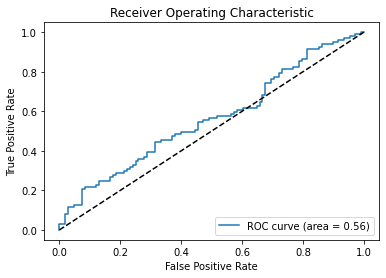

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import networkx as nx
from tqdm import tqdm
import dgl

# Your provided functions
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

# Assuming BrainDataset is defined and loaded as before
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Function to calculate edge centrality measures
def calculate_edge_centrality(graphs):
    edge_centrality = []
    for graph in tqdm(graphs, desc='Calculating edge centralities'):
        nx_graph = to_simple_graph(graph)
        edge_centrality.append(nx.edge_betweenness_centrality(nx_graph, normalized=True))
    return edge_centrality

# Function to aggregate edge centrality measures
def aggregate_edge_features(graphs, significant_edges, edge_centrality):
    edge_features = []
    for graph, centrality_dict in zip(graphs, edge_centrality):
        graph_edge_features = []
        for edge in significant_edges:
            # Check if the edge exists and if its centrality was computed
            if edge in centrality_dict:
                graph_edge_features.append(centrality_dict[edge])
            else:
                graph_edge_features.append(0)  # Edge absent or centrality not computed
        edge_features.append(graph_edge_features)
    return np.array(edge_features)

# Load significant edges
df_edges = pd.read_csv('significant_edges.csv')
significant_edges = [(int(row['Edge'].split('-')[0]), int(row['Edge'].split('-')[1])) for index, row in df_edges.iterrows()]

# Calculate edge centrality measures for each graph
edge_centrality = calculate_edge_centrality(graphs)

# Extract aggregated edge features
X_edges = aggregate_edge_features(graphs, significant_edges, edge_centrality)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_edges, labels, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100, 150, 200, 250, 500, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=10, verbose=1, n_jobs=-1)

# Fit GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for predictions
y_pred = grid_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Assuming decision_function for ROC AUC calculation
y_score = grid_search.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_score)
print("ROC AUC:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Looking at features: Nodes and Edges

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import networkx as nx
from tqdm import tqdm
import dgl  # Ensure DGL is installed

# Your provided functions
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

# Assuming BrainDataset is defined and loaded as before
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Updated centrality measures calculation including leverage centrality
def calculate_centrality_measures(graphs):
    centrality_measures = {
        'degree': [],
        'betweenness': [],
        'closeness': [],
        'eigenvector': [],
        'leverage': [],
    }

    for graph in tqdm(graphs, desc='Calculating centrality measures'):
        nx_graph = to_simple_graph(graph)  # Convert DGL graph to NetworkX graph
        centrality_measures['degree'].append(nx.degree_centrality(nx_graph))
        centrality_measures['betweenness'].append(nx.betweenness_centrality(nx_graph))
        centrality_measures['closeness'].append(nx.closeness_centrality(nx_graph))
        centrality_measures['eigenvector'].append(nx.eigenvector_centrality(nx_graph, max_iter=1000))
        centrality_measures['leverage'].append(compute_leverage_centrality(nx_graph))
        
    return centrality_measures

# Aggregate features based on centrality measures
def aggregate_features(centrality_measures, significant_nodes):
    aggregated_features = []

    for measures_list in zip(*centrality_measures.values()):
        graph_features = []
        for measures in measures_list:
            significant_measures = [measures[node] for node in significant_nodes if node in measures]
            if significant_measures:
                mean = np.mean(significant_measures)
                median = np.median(significant_measures)
                std = np.std(significant_measures)
            else:
                mean, median, std = 0, 0, 0  # Default values in absence
            graph_features.extend([mean, median, std])
        aggregated_features.append(graph_features)
    
    return np.array(aggregated_features)

def aggregate_edge_features(graphs, significant_edges):
    edge_features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_edge_features = []
        
        for edge in significant_edges:
            # Assuming edges are tuples (u, v)
            u, v = edge
            if nx_graph.has_edge(u, v):
                weight = nx_graph[u][v].get('weight', 1.0)  # Default to 1.0 if not weighted
                graph_edge_features.append(weight)
            else:
                graph_edge_features.append(0)  # Edge absent

        edge_features.append(graph_edge_features)

    return np.array(edge_features)

# Load CSV files for significant nodes and edges
df_nodes = pd.read_csv('significant_nodes.csv')
significant_nodes = df_nodes['Node'].unique().tolist()

# Calculate centrality measures for each graph
centrality_measures = calculate_centrality_measures(graphs)

# Extract aggregated features using the updated aggregation function that includes leverage
X = aggregate_features(centrality_measures, significant_nodes)
y = np.array(labels)

# Load significant edges
df_edges = pd.read_csv('significant_edges.csv')
significant_edges = [(int(row['Edge'].split('-')[0]), int(row['Edge'].split('-')[1])) for index, row in df_edges.iterrows()]

# Calculate edge features for each graph
edge_features = aggregate_edge_features(graphs, significant_edges)

# Combine node and edge features
X = np.concatenate((X, edge_features), axis=1)  
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100, 150, 200, 250, 500, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=10, verbose=1, n_jobs=-1)

# Fit GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for predictions
y_pred = grid_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Assuming decision_function for ROC AUC calculation
y_score = grid_search.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_score)
print("ROC AUC:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  3%|▎         | 32/1025 [00:00<00:03, 316.91it/s]

[!] Dataset:  Abide100Dataset
[]


Calculating centrality measures:   0%|          | 1/1025 [00:00<02:25,  7.03it/s]

Time taken: 3.1343s


Calculating centrality measures: 100%|██████████| 1025/1025 [02:14<00:00,  7.63it/s]


ValueError: invalid literal for int() with base 10: '(0, 0)'

#### Graphlets & Motifs

In [4]:
from graph_tool import
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a function to load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert NetworkX graphs to graph-tool graphs
def convert_to_graphtool(nx_graphs):
    gt_graphs = []
    for g in nx_graphs:
        gt_g = Graph(directed=False)
        # Assuming 'g' is a NetworkX graph, add vertices
        vprop = gt_g.new_vertex_property("int")
        for n in g.nodes():
            v = gt_g.add_vertex()
            vprop[v] = n
        # Add edges
        for e in g.edges():
            gt_g.add_edge(gt_g.vertex(vprop[e[0]]), gt_g.vertex(vprop[e[1]]))
        gt_graphs.append(gt_g)
    return gt_graphs

gt_graphs = convert_to_graphtool(graphs)

# Now, we can count triangles using graph-tool
def count_triangles(gt_graphs):
    triangle_counts = []
    for g in gt_graphs:
        # graph_tool.clustering.global_clustering() returns a tuple, where the third value is the count of triangles
        _, _, triangles = global_clustering(g)
        triangle_counts.append(triangles)
    return triangle_counts

triangle_features = np.array(count_triangles(gt_graphs)).reshape(-1, 1)

# Use these triangle features as your X in the machine learning workflow
X = triangle_features
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train SVM
clf = SVC(kernel='linear')
clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Assuming decision_function for ROC AUC calculation
y_score = clf.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_score)
print("ROC AUC:", roc_auc)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ImportError: /home/marcus/anaconda3/envs/gt/lib/python3.12/site-packages/torch/lib/libgomp-a34b3233.so.1: version `GOMP_5.0' not found (required by /home/marcus/anaconda3/envs/gt/lib/python3.12/site-packages/graph_tool/libgraph_tool_core.so)

#### More complex SVM (Using centrality measures as features) - using mean of centrality scores

In [29]:
import numpy as np
import networkx as nx
import dgl
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Define the centrality computation functions
def compute_centrality_measures(graphs):
    centrality_features = []
    for graph in graphs:
        nx_graph = dgl.to_networkx(graph).to_undirected()
        nx_graph = nx.Graph(nx_graph)  # Converting multigraph to graph

        betweenness = nx.betweenness_centrality(nx_graph)
        closeness = nx.closeness_centrality(nx_graph)
        eigenvector = nx.eigenvector_centrality(nx_graph, max_iter=1000, tol=1e-06)
        leverage = compute_leverage_centrality(nx_graph)

        # Here we take the mean of the centrality measures for each graph
        centrality_features.append([
            np.mean(list(betweenness.values())),
            np.mean(list(closeness.values())),
            np.mean(list(eigenvector.values())),
            np.mean(list(leverage.values()))
        ])

    return np.array(centrality_features)

def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:  # Avoid division by zero for isolated nodes
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

# Define functions to save and load features
def save_features(features, labels, filename="features.npy"):
    np.save(filename, features)
    np.save("labels.npy", labels)

def load_features(filename="features.npy"):
    features = np.load(filename)
    labels = np.load("labels.npy")
    return features, labels

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Compute centrality features
centrality_features = compute_centrality_measures(graphs)

# Save the centrality features and labels
save_features(centrality_features, labels)

# Load the features and labels
features, labels = load_features()

# Preprocess the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Train the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Save the trained SVM model and the scaler
joblib.dump(svm_classifier, 'svm_classifier.joblib')
joblib.dump(scaler, 'scaler.joblib')

  4%|▎         | 37/1025 [00:00<00:02, 365.86it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 427.24it/s]


Time taken: 2.9115s
Accuracy: 52.68%


['scaler.joblib']

In [30]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100],  # Example C values, you may want to choose a wider or more granular range
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],  # Example gamma values, including 'scale' and 'auto'
    'kernel': ['linear', 'rbf', 'poly']  # Trying out different kernels
}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model with the grid search
grid_search.fit(X_train, y_train)

# View the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Use the best estimator to make predictions
best_svm_classifier = grid_search.best_estimator_
y_pred = best_svm_classifier.predict(X_test)

# Evaluate the classifier with the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with optimized hyperparameters: {accuracy * 100:.2f}%')

# Save the best SVM model and the scaler
joblib.dump(best_svm_classifier, 'best_svm_classifier.joblib')

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best parameters found:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validated accuracy: 53.05%
Accuracy with optimized hyperparameters: 51.71%


['best_svm_classifier.joblib']

#### Testing all permutations just to be safe

In [31]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

from itertools import combinations
import numpy as np

# Simulated feature data for demonstration (replace with your actual data)
np.random.seed(42)  # For reproducible results
num_samples = 100  # Number of samples in your dataset
X_simulated = np.random.rand(num_samples, 4)  # Simulate some feature data
y_simulated = np.random.randint(0, 2, size=num_samples)  # Simulate binary labels

feature_names = ['betweenness', 'closeness', 'eigenvector', 'leverage']
feature_indices = range(len(feature_names))

# Generate all permutations of the features
feature_combinations = [comb for i in range(1, len(feature_names) + 1) for comb in combinations(feature_indices, i)]


# Define the parameter grid
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Function to perform Grid Search CV on a given feature set
def perform_grid_search(X, y, feature_set):
    X_train, X_test, y_train, y_test = train_test_split(X[:, feature_set], y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Grid Search CV
    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid, scoring='accuracy', cv=5, verbose=0)
    grid_search.fit(X_train_scaled, y_train)

    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, best_model.decision_function(X_test_scaled))

    return grid_search.best_params_, accuracy, auc_score

# Iterate over each permutation and perform Grid Search CV
results = []
for feature_set in feature_combinations:
    best_params, accuracy, auc_score = perform_grid_search(X_simulated, y_simulated, feature_set)
    results.append({
        'features': [feature_names[i] for i in feature_set],
        'best_params': best_params,
        'accuracy': accuracy,
        'auc_score': auc_score
    })

# Find the permutation with the highest accuracy
best_result = max(results, key=lambda x: x['accuracy'])
print(f"Best Feature Combination: {best_result['features']}")
print(f"Best Hyperparameters: {best_result['best_params']}")
print(f"Best Accuracy: {best_result['accuracy']:.4f}")
print(f"Best AUC Score: {best_result['auc_score']:.4f}")


Best Feature Combination: ['betweenness']
Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Accuracy: 0.6500
Best AUC Score: 0.3736


In [5]:
import numpy as np
import networkx as nx
import dgl
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import joblib
from tqdm import tqdm
import multiprocessing as mp
import os

def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

def compute_centrality_for_graph(graph):
    nx_graph = dgl.to_networkx(graph).to_undirected()
    nx_graph = nx.Graph(nx_graph)
    betweenness = nx.betweenness_centrality(nx_graph)
    closeness = nx.closeness_centrality(nx_graph)
    eigenvector = nx.eigenvector_centrality(nx_graph, max_iter=1000, tol=1e-06)
    leverage = compute_leverage_centrality(nx_graph)
    return [np.mean(list(betweenness.values())), np.mean(list(closeness.values())), np.mean(list(eigenvector.values())), np.mean(list(leverage.values()))]

def parallel_compute_centrality_measures(graphs):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        centrality_features = pool.map(compute_centrality_for_graph, graphs)
    return np.array(centrality_features)

def save_features(features, labels, filename="features.npy"):
    np.save(filename, features)
    np.save("labels.npy", labels)

def load_features(filename="features.npy"):
    features = np.load(filename)
    labels = np.load("labels.npy")
    return features, labels

def cache_and_load_centrality_features(graphs, labels, filename="features.npy"):
    if os.path.exists(filename) and os.path.exists("labels.npy"):
        print("Loading cached features...")
        return load_features(filename)
    else:
        print("Computing and caching features...")
        centrality_features = parallel_compute_centrality_measures(graphs)
        save_features(centrality_features, labels, filename)
        return centrality_features, labels

def perform_grid_search(X, y, feature_set, param_grid):
    X_train, X_test, y_train, y_test = train_test_split(X[:, feature_set], y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, best_model.decision_function(X_test_scaled))
    return grid_search.best_params_, accuracy, auc_score


Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

features, labels = cache_and_load_centrality_features(graphs, labels)

param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100, 150, 200, 250, 500, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

feature_names = ['betweenness', 'closeness', 'eigenvector', 'leverage']
feature_combinations = [comb for i in range(1, len(feature_names) + 1) for comb in combinations(range(len(feature_names)), i)]

results = []
for feature_set in tqdm(feature_combinations, desc="Evaluating Feature Sets"):
    best_params, accuracy, auc_score = perform_grid_search(features, labels, feature_set, param_grid)
    results.append({
        'features': [feature_names[i] for i in feature_set],
        'best_params': best_params,
        'accuracy': accuracy,
        'auc_score': auc_score
    })

best_result = max(results, key=lambda x: x['accuracy'])
print(f"Best Feature Combination: {best_result['features']}")
print(f"Best Hyperparameters: {best_result['best_params']}")
print(f"Best Accuracy: {best_result['accuracy']:.4f}")
print(f"Best AUC Score: {best_result['auc_score']:.4f}")

  4%|▍         | 44/1025 [00:00<00:02, 430.61it/s]

[!] Dataset:  Abide100Dataset
[]


Evaluating Feature Sets:   0%|          | 0/15 [00:00<?, ?it/s]

Time taken: 2.8275s
Loading cached features...


Evaluating Feature Sets: 100%|██████████| 15/15 [16:30<00:00, 66.05s/it]

Best Feature Combination: ['closeness', 'eigenvector']
Best Hyperparameters: {'C': 500, 'gamma': 0.1, 'kernel': 'rbf'}
Best Accuracy: 0.5561
Best AUC Score: 0.5772


#### Top k nodes

Previously, I was using mean of top centrality features. That didn't rly help. 

In [9]:
import numpy as np
import networkx as nx
import dgl
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tqdm import tqdm
import multiprocessing as mp
from itertools import combinations


def compute_centrality_for_graph_full(nx_graph, measures):
    centralities = {}
    if 'betweenness' in measures:
        centralities['betweenness'] = nx.betweenness_centrality(nx_graph)
    if 'closeness' in measures:
        centralities['closeness'] = nx.closeness_centrality(nx_graph)
    if 'eigenvector' in measures:
        centralities['eigenvector'] = nx.eigenvector_centrality(nx_graph, max_iter=1000, tol=1e-06)
    if 'leverage' in measures:
        centralities['leverage'] = compute_leverage_centrality(nx_graph)
    return centralities

def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

def compute_and_select_top_k_features(graph, k=5, centrality_measures=['betweenness', 'closeness', 'eigenvector', 'leverage']):
    nx_graph = dgl.to_networkx(graph).to_undirected()
    nx_graph = nx.Graph(nx_graph)  # Ensure we're working with a simple graph
    centralities = compute_centrality_for_graph_full(nx_graph, centrality_measures)
    
    top_k_features = []
    feature_metadata = []  # Track which features are used
    for measure in centrality_measures:
        sorted_nodes = sorted(centralities[measure].items(), key=lambda item: item[1], reverse=True)[:k]
        top_k_features.extend([value for _, value in sorted_nodes])
        feature_metadata.extend([(measure, node) for node, value in sorted_nodes])
    
    return np.array(top_k_features), feature_metadata

def worker_task(args):
    return compute_and_select_top_k_features(*args)

def parallel_compute_top_k_features(graphs, k=5, centrality_measures=['betweenness', 'closeness', 'eigenvector', 'leverage']):
    iterable = [(graph, k, centrality_measures) for graph in graphs]
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = list(tqdm(pool.imap(worker_task, iterable), total=len(graphs), desc=f"Processing graphs with {', '.join(centrality_measures)}"))
    top_k_features, metadata = zip(*results)
    return np.array(top_k_features), metadata

def extract_features_and_labels(dataset_split):
    # Assuming dataset_split is an iterable of (graph, label) tuples
    graphs, labels = zip(*dataset_split)  # Directly unpack without assuming dictionary structure
    features, metadata = parallel_compute_top_k_features(graphs)  # This remains the same
    return np.array(features), np.array(labels)


def classify_with_svm(X_train_scaled, y_train, X_test_scaled, y_test, param_grid):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    try:
        auc_score = roc_auc_score(y_test, best_model.decision_function(X_test_scaled))
    except:
        auc_score = "AUC not applicable"
    
    return grid_search.best_params_, accuracy, auc_score

# Generate combinations of centrality measures
all_centrality_measures = ['betweenness', 'closeness', 'eigenvector', 'leverage']
centrality_combinations = [combo for i in range(1, len(all_centrality_measures)+1) 
                           for combo in combinations(all_centrality_measures, i)]

def main():
    # Adjust these paths as necessary
    train_set = Abide100.train
    test_set = Abide100.test

    X_train, y_train = extract_features_and_labels(train_set)
    X_test, y_test = extract_features_and_labels(test_set)

    # Scale features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }

    best_params, accuracy, auc_score = classify_with_svm(X_train_scaled, y_train, X_test_scaled, y_test, param_grid)
    print(f"Best Parameters: {best_params}, Accuracy: {accuracy}, AUC Score: {auc_score}")

if __name__ == "__main__":
    Abide100 = BrainDataset('Abide100Dataset')
    graphs, labels = zip(*[(graph, label) for graph, label in Abide100])
    main()

  4%|▍         | 44/1025 [00:00<00:02, 432.57it/s]

[!] Dataset:  Abide100Dataset
[]


 56%|█████▋    | 578/1025 [00:01<00:01, 445.04it/s]

100%|██████████| 1025/1025 [00:02<00:00, 426.48it/s]


Time taken: 2.9904s


ValueError: too many values to unpack (expected 2)

In [7]:
print(Abide100.train[1])  # Example to understand the structure of a single dataset item

In [38]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import networkx as nx
import dgl
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import multiprocessing as mp
from joblib import dump, load


def compute_leverage_centrality(nx_graph):
    leverage_centrality = {}
    for node in nx_graph.nodes():
        node_degree = nx_graph.degree(node)
        neighbors = list(nx_graph.neighbors(node))
        if node_degree == 0:
            leverage_centrality[node] = 0
        else:
            leverage_sum = 0
            for neighbor in neighbors:
                neighbor_degree = nx_graph.degree(neighbor)
                leverage_sum += (node_degree - neighbor_degree) / (node_degree + neighbor_degree)
            leverage_centrality[node] = leverage_sum / node_degree
    return leverage_centrality

def create_feature_vectors(graphs, significant_nodes):
    feature_vectors = []
    for graph in tqdm(graphs, desc="Creating feature vectors"):
        # Convert DGL graph to NetworkX graph, ensuring a simple graph format
        nx_multigraph = dgl.to_networkx(graph).to_undirected()
        nx_graph = nx.Graph()
        for u, v, data in nx_multigraph.edges(data=True):
            w = data['weight'] if 'weight' in data else 1.0
            if nx_graph.has_edge(u, v):
                nx_graph[u][v]['weight'] += w
            else:
                nx_graph.add_edge(u, v, weight=w)
        
        # Compute all centralities
        betweenness_centrality = nx.betweenness_centrality(nx_graph, weight='weight')
        eigenvector_centrality = nx.eigenvector_centrality(nx_graph, weight='weight', max_iter=1000, tol=1e-06)
        leverage_centrality = compute_leverage_centrality(nx_graph)
        closeness_centrality = nx.closeness_centrality(nx_graph, distance='weight')  # Ensure to handle weighted closeness if applicable
        
        feature_vector = []
        for node in significant_nodes:
            features = [
                betweenness_centrality.get(node, 0),
                eigenvector_centrality.get(node, 0),
                leverage_centrality.get(node, 0),
                closeness_centrality.get(node, 0)
            ]
            feature_vector.extend(features)
        
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)



# Generate feature vectors with extended centralities
feature_vectors = create_feature_vectors(graphs, significant_nodes)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100, 150, 200, 250, 500, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Save the best model and grid search results
joblib.dump(grid_search.best_estimator_, 'best_svm_model.pkl')
joblib.dump(grid_search.cv_results_, 'grid_search_results.pkl')

# After running GridSearchCV
# Define best_model as the best estimator found by GridSearchCV
best_model = grid_search.best_estimator_

# Now you can use best_model for predictions
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# Check if the best model supports decision_function
if hasattr(best_model, "decision_function"):
    decision_function_values = best_model.decision_function(X_test_scaled)
    try:
        auc_score = roc_auc_score(y_test, decision_function_values)
    except ValueError:
        auc_score = float('nan')
    print(f"AUC Score: {auc_score:.4f}")
else:
    print("AUC Score cannot be calculated for this model configuration.")

significant_nodes_info = {
    'betweenness': {}, # Assuming a function exists to populate these based on your criteria
    'eigenvector': {},
    'leverage': {},
    'closeness': {}
}
# Populate significant_nodes_info based on your computed centralities and criteria

joblib.dump(significant_nodes_info, 'significant_nodes_info.pkl')

Creating feature vectors: 100%|██████████| 1025/1025 [06:37<00:00,  2.58it/s]

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


AUC Score: 0.5833


['significant_nodes_info.pkl']

In [31]:
from scipy.stats import ttest_ind
import numpy as np
import dgl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from joblib import dump

# Function to calculate weighted degrees
def calculate_weighted_degrees(graph):
    # Initialize an array to hold the weighted degree for each node
    weighted_degrees = np.zeros(graph.number_of_nodes())
    
    # Access source and destination nodes directly
    src, dst = graph.edges()
    
    # Assuming edge weights are stored in 'feat'
    edge_weights = graph.edata['feat'].numpy()
    
    # Accumulate edge weights to compute weighted degrees
    # Note: This loop is unnecessary if your operations are vectorized
    for i in range(len(src)):
        weighted_degrees[src[i]] += edge_weights[i]
        weighted_degrees[dst[i]] += edge_weights[i]

    return weighted_degrees

# Function to compare weighted degrees across labels and find significant nodes
def compare_weighted_degrees(graphs, labels):
    weighted_degrees = {0: [], 1: []}

    for graph, label in zip(graphs, labels):
        w_degrees = calculate_weighted_degrees(graph)
        weighted_degrees[label].append(w_degrees)

    weighted_degrees[0] = np.array(weighted_degrees[0])
    weighted_degrees[1] = np.array(weighted_degrees[1])

    p_values = []
    t_statistics = []
    node_indices = np.arange(weighted_degrees[0].shape[1])
    for node_index in node_indices:
        t_stat, p_val = ttest_ind(weighted_degrees[0][:, node_index], weighted_degrees[1][:, node_index], nan_policy='omit')
        t_statistics.append(t_stat)
        p_values.append(p_val)

    significant_indices = [i for i, p_val in enumerate(p_values) if p_val < 0.05]
    significant_p_values = [p_values[i] for i in significant_indices]
    sorted_significant_indices = sorted(range(len(significant_p_values)), key=lambda i: significant_p_values[i])
    top_indices = [significant_indices[i] for i in sorted_significant_indices[:10]]

    return top_indices, significant_p_values, p_values, t_statistics

# Assuming graphs and labels are already loaded
top_indices, significant_p_values, p_values, t_statistics = compare_weighted_degrees(graphs, labels)

# Extract features based on significant nodes
def create_feature_vectors(graphs, significant_nodes):
    feature_vectors = []
    for graph in tqdm(graphs, desc="Creating feature vectors"):
        w_degrees = calculate_weighted_degrees(graph)
        feature_vector = [w_degrees[node] for node in significant_nodes]
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

feature_vectors = create_feature_vectors(graphs, top_indices)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 0.5, 1, 5, 10, 50, 100, 150, 200, 250, 500, 1000],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Save the best model
dump(grid_search.best_estimator_, 'best_svm_model.joblib')

# Predictions and Evaluation
y_pred = grid_search.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Creating feature vectors: 100%|██████████| 1025/1025 [00:27<00:00, 37.75it/s]


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Accuracy: 0.5659


## Logistic Regression

##### With features

  4%|▍         | 42/1025 [00:00<00:02, 414.33it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 417.42it/s]


Time taken: 3.1296s
Fitting 10 folds for each of 15 candidates, totalling 150 fits


/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.5        0.60741439        nan 0.59864618 0.59560855        nan
 0.57032562 0.5899441         nan 0.57593353 0.58952658        nan
 0.58875181 0.5888699         nan]
  warnings.warn(


Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.6097560975609756
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       108
           1       0.59      0.59      0.59        97

    accuracy                           0.61       205
   macro avg       0.61      0.61      0.61       205
weighted avg       0.61      0.61      0.61       205



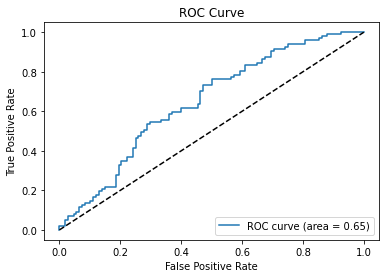

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Logistic Regression model
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
fpr, tpr, _ = roc_curve(y_test, grid_search.decision_function(X_test_scaled))
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 39/1025 [00:00<00:02, 383.77it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 427.45it/s]


Time taken: 3.0446s
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
Best parameters: {'C': 0.001, 'class_weight': None, 'l1_ratio': 0.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.526829268292683
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       108
           1       0.00      0.00      0.00        97

    accuracy                           0.53       205
   macro avg       0.26      0.50      0.35       205
weighted avg       0.28      0.53      0.36       205



/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMet

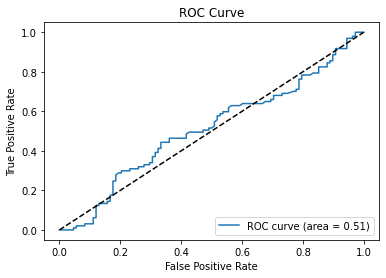

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Logistic Regression model
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga'],  # Most flexible solver, supporting all penalties
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 1000, 10000],
    # When using 'elasticnet', you should also include 'l1_ratio'
    'l1_ratio': np.linspace(0, 1, num=10)  # Only when 'penalty' is 'elasticnet'
}



grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
roc_auc = roc_auc_score(y_test, grid_search.decision_function(X_test_scaled))
fpr, tpr, _ = roc_curve(y_test, grid_search.decision_function(X_test_scaled))
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Decision Trees

  4%|▍         | 43/1025 [00:00<00:02, 428.27it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 430.05it/s]


Time taken: 2.9848s
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy: 0.526829268292683
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       108
           1       0.50      0.46      0.48        97

    accuracy                           0.53       205
   macro avg       0.52      0.52      0.52       205
weighted avg       0.53      0.53      0.53       205



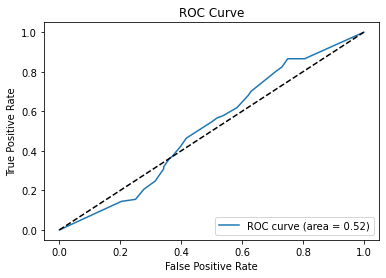

In [14]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Decision Tree model
param_grid = {
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Since decision trees do not output decision functions in the same way as logistic regression,
# we modify the ROC curve plotting accordingly if needed. Here, we'll use `predict_proba` to get the probabilities for the positive class.
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  3%|▎         | 33/1025 [00:00<00:03, 322.89it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 420.13it/s]


Time taken: 3.0057s
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy: 0.5121951219512195
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       108
           1       0.47      0.25      0.32        97

    accuracy                           0.51       205
   macro avg       0.50      0.50      0.47       205
weighted avg       0.50      0.51      0.48       205



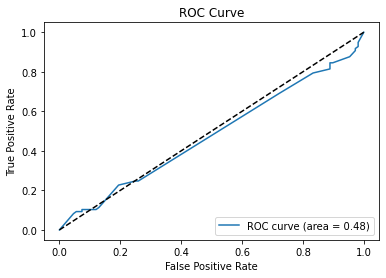

In [15]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier  # Changed from LogisticRegression to DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import ast
import networkx as nx
from collections import defaultdict

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Decision Tree model
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criteria for choosing nodes
    'max_depth': [None, 10, 20, 30, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create a decision tree classifier instance with GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)  # Fit the model

# Evaluation
print("Best parameters:", grid_search.best_params_)  # Print best parameter set
y_pred = grid_search.predict(X_test_scaled)  # Predict on the test set
print("Accuracy:", accuracy_score(y_test, y_pred))  # Print accuracy
print(classification_report(y_test, y_pred))  # Print classification report

# Since Decision Trees do not support decision_function, we use predict_proba for ROC curve
probabilities = grid_search.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, probabilities)  # Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_test, probabilities)  # Calculate FPR and TPR for ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Plot the no skill line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forests

  3%|▎         | 35/1025 [00:00<00:02, 344.48it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 422.29it/s]


Time taken: 2.9134s
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.6195121951219512
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       108
           1       0.64      0.45      0.53        97

    accuracy                           0.62       205
   macro avg       0.62      0.61      0.61       205
weighted avg       0.62      0.62      0.61       205



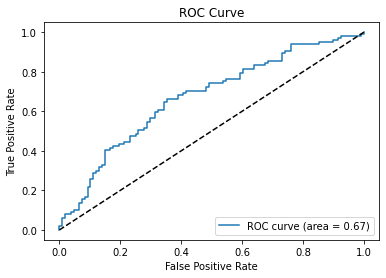

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Random Forest model
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 43/1025 [00:00<00:02, 425.56it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 426.91it/s]


Time taken: 2.9791s
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.4878048780487805
              precision    recall  f1-score   support

           0       0.51      0.50      0.51       108
           1       0.46      0.47      0.47        97

    accuracy                           0.49       205
   macro avg       0.49      0.49      0.49       205
weighted avg       0.49      0.49      0.49       205



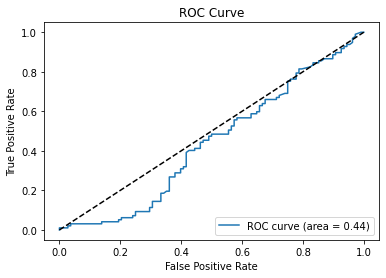

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Random Forest model
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Gradient Boosting Machines

  4%|▍         | 43/1025 [00:00<00:02, 423.55it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 425.43it/s]


Time taken: 3.0150s
Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.75}
Accuracy: 0.5804878048780487
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       108
           1       0.58      0.43      0.49        97

    accuracy                           0.58       205
   macro avg       0.58      0.57      0.57       205
weighted avg       0.58      0.58      0.57       205



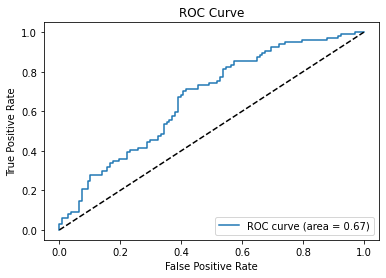

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Gradient Boosting model
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'subsample': [0.5, 0.75, 1.0],  # Fraction of samples to be used for fitting the individual base learners
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 42/1025 [00:00<00:02, 415.71it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 430.12it/s]


Time taken: 2.8639s
Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best parameters: {'learning_rate': 1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.5}
Accuracy: 0.47317073170731705
              precision    recall  f1-score   support

           0       0.50      0.53      0.51       108
           1       0.44      0.41      0.43        97

    accuracy                           0.47       205
   macro avg       0.47      0.47      0.47       205
weighted avg       0.47      0.47      0.47       205



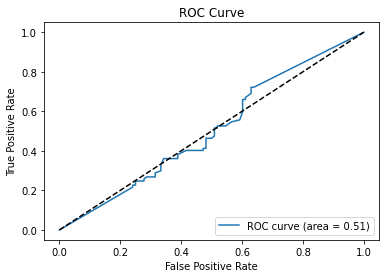

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the Gradient Boosting model
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'subsample': [0.5, 0.75, 1.0],  # Fraction of samples to be used for fitting the individual base learners
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## k-Nearest Neighbours

  3%|▎         | 31/1025 [00:00<00:03, 309.66it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 427.33it/s]


Time taken: 2.8622s
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy: 0.551219512195122
              precision    recall  f1-score   support

           0       0.55      0.81      0.65       108
           1       0.55      0.27      0.36        97

    accuracy                           0.55       205
   macro avg       0.55      0.54      0.51       205
weighted avg       0.55      0.55      0.52       205



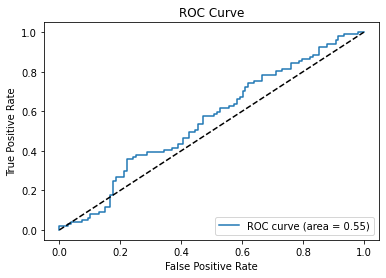

In [20]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the k-NN model
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Typical odd numbers to avoid ties
    'weights': ['uniform', 'distance'],  # Weighting function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric for tree search
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Since k-NN does not provide a decision_function, we use predict_proba for ROC curve plotting
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 43/1025 [00:00<00:02, 428.50it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 418.84it/s]


Time taken: 3.0356s
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.4585365853658537
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       108
           1       0.43      0.41      0.42        97

    accuracy                           0.46       205
   macro avg       0.46      0.46      0.46       205
weighted avg       0.46      0.46      0.46       205



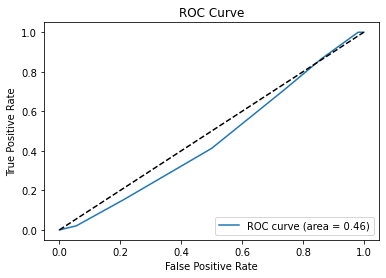

In [21]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the k-NN model
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Typical odd numbers to avoid ties
    'weights': ['uniform', 'distance'],  # Weighting function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric for tree search
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Since k-NN does not provide a decision_function, we use predict_proba for ROC curve plotting
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes

  4%|▍         | 43/1025 [00:00<00:02, 426.87it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 431.97it/s]


Time taken: 2.8566s
Accuracy: 0.5853658536585366
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       108
           1       0.55      0.64      0.59        97

    accuracy                           0.59       205
   macro avg       0.59      0.59      0.59       205
weighted avg       0.59      0.59      0.58       205



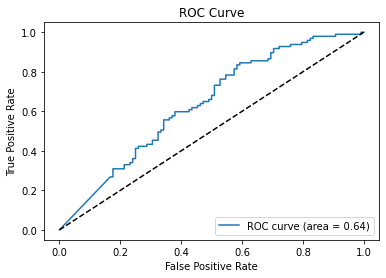

In [22]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the Naive Bayes model
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# Note: GaussianNB supports predict_proba, which is used for calculating the ROC curve.
probs = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 43/1025 [00:00<00:02, 427.12it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 418.85it/s]


Time taken: 2.9199s
Accuracy: 0.4975609756097561
              precision    recall  f1-score   support

           0       0.51      0.81      0.63       108
           1       0.41      0.14      0.21        97

    accuracy                           0.50       205
   macro avg       0.46      0.48      0.42       205
weighted avg       0.47      0.50      0.43       205



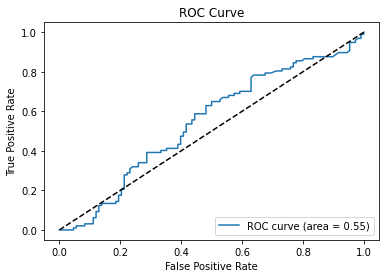

In [23]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the Naive Bayes model
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# Note: GaussianNB supports predict_proba, which is used for calculating the ROC curve.
probs = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Stochastic Gradient Descent (SGD)

  4%|▍         | 44/1025 [00:00<00:02, 433.52it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 435.01it/s]


Time taken: 2.9727s
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters: {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'invscaling', 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1'}
Accuracy: 0.6390243902439025
              precision    recall  f1-score   support

           0       0.64      0.71      0.68       108
           1       0.64      0.56      0.59        97

    accuracy                           0.64       205
   macro avg       0.64      0.63      0.63       205
weighted avg       0.64      0.64      0.64       205



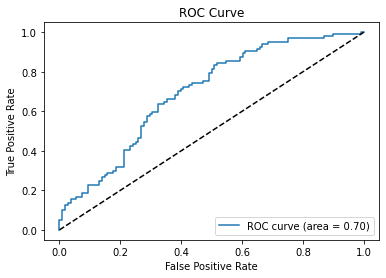

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the SGD model
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],  # Different loss functions
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
    'max_iter': [1000, 5000, 10000],  # Number of iterations
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01],  # Initial learning rate for the 'constant', 'invscaling' or 'adaptive' schedules
}

grid_search = GridSearchCV(SGDClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve might need adjustment as SGDClassifier does not directly provide probabilities
# for non-logistic regression losses. Here we use the decision function for the ROC curve if loss='log'.
if 'log' in grid_search.best_params_['loss']:
    probabilities = grid_search.decision_function(X_test_scaled)
else:
    probabilities = grid_search.predict(X_test_scaled)  # Fallback or customize as needed
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▎         | 36/1025 [00:00<00:02, 359.95it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 429.03it/s]


Time taken: 2.8507s
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters: {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Accuracy: 0.526829268292683
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       108
           1       0.00      0.00      0.00        97

    accuracy                           0.53       205
   macro avg       0.26      0.50      0.35       205
weighted avg       0.28      0.53      0.36       205



/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


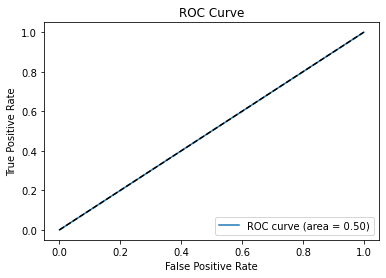

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the SGD model
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],  # Different loss functions
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
    'max_iter': [1000, 5000, 10000],  # Number of iterations
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01],  # Initial learning rate for the 'constant', 'invscaling' or 'adaptive' schedules
}

grid_search = GridSearchCV(SGDClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve might need adjustment as SGDClassifier does not directly provide probabilities
# for non-logistic regression losses. Here we use the decision function for the ROC curve if loss='log'.
if 'log' in grid_search.best_params_['loss']:
    probabilities = grid_search.decision_function(X_test_scaled)
else:
    probabilities = grid_search.predict(X_test_scaled)  # Fallback or customize as needed
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## AdaBoost

  4%|▍         | 43/1025 [00:00<00:02, 425.24it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 428.65it/s]


Time taken: 2.8946s
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 0.5853658536585366
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       108
           1       0.57      0.51      0.54        97

    accuracy                           0.59       205
   macro avg       0.58      0.58      0.58       205
weighted avg       0.58      0.59      0.58       205



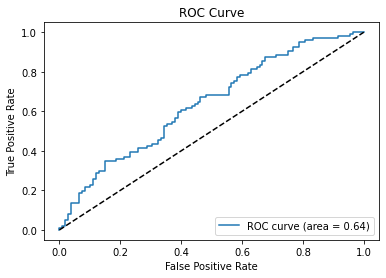

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the AdaBoost model
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of weak classifiers
    'learning_rate': [0.01, 0.1, 1],  # Weight contributions of each classifier
}

grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# AdaBoost supports predict_proba method, which is used for calculating the ROC curve.
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 42/1025 [00:00<00:02, 418.15it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 422.89it/s]


Time taken: 3.0386s
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Accuracy: 0.526829268292683
              precision    recall  f1-score   support

           0       0.54      0.72      0.62       108
           1       0.50      0.31      0.38        97

    accuracy                           0.53       205
   macro avg       0.52      0.52      0.50       205
weighted avg       0.52      0.53      0.51       205



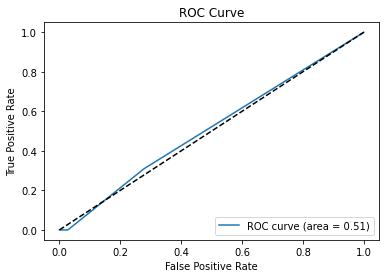

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and optimize the AdaBoost model
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of weak classifiers
    'learning_rate': [0.01, 0.1, 1],  # Weight contributions of each classifier
}

grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# AdaBoost supports predict_proba method, which is used for calculating the ROC curve.
probs = grid_search.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Quadratic Discriminant Analysis

  4%|▍         | 43/1025 [00:00<00:02, 425.14it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 427.35it/s]


Time taken: 3.0143s
Accuracy: 0.4634146341463415
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       108
           1       0.45      0.56      0.50        97

    accuracy                           0.46       205
   macro avg       0.47      0.47      0.46       205
weighted avg       0.47      0.46      0.46       205



/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


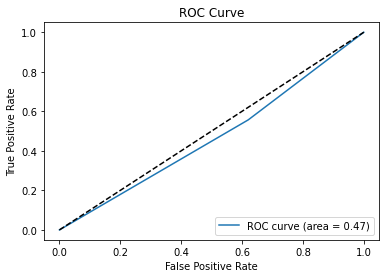

In [28]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the QDA model
model = QuadraticDiscriminantAnalysis()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# QDA supports the predict_proba method, which is used for calculating the ROC curve.
probs = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the QDA model
model = QuadraticDiscriminantAnalysis()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# QDA supports the predict_proba method, which is used for calculating the ROC curve.
probs = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 44/1025 [00:00<00:02, 430.62it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 423.91it/s]


Time taken: 3.0479s
Accuracy: 0.526829268292683
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       108
           1       0.00      0.00      0.00        97

    accuracy                           0.53       205
   macro avg       0.26      0.50      0.35       205
weighted avg       0.28      0.53      0.36       205



/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/marcus/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Linear Discriminant Analysis

  4%|▍         | 43/1025 [00:00<00:02, 429.82it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 434.64it/s]


Time taken: 2.9870s
Accuracy: 0.5317073170731708
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       108
           1       0.50      0.59      0.54        97

    accuracy                           0.53       205
   macro avg       0.53      0.53      0.53       205
weighted avg       0.54      0.53      0.53       205



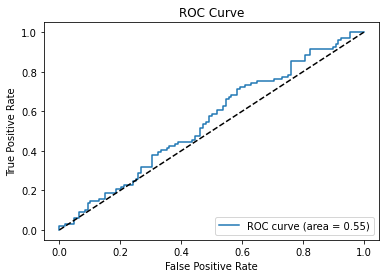

In [31]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the LDA model
model = LinearDiscriminantAnalysis()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# LDA supports the predict_proba method, which is used for calculating the ROC curve.
probs = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 43/1025 [00:00<00:02, 428.08it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 429.96it/s]


Time taken: 2.8822s
Accuracy: 0.5121951219512195
              precision    recall  f1-score   support

           0       0.52      0.85      0.65       108
           1       0.45      0.13      0.21        97

    accuracy                           0.51       205
   macro avg       0.49      0.49      0.43       205
weighted avg       0.49      0.51      0.44       205



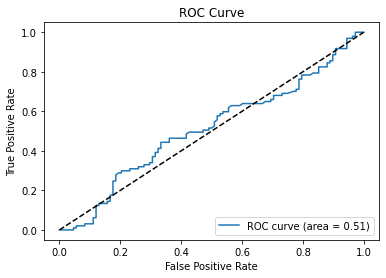

In [32]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the LDA model
model = LinearDiscriminantAnalysis()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve
# LDA supports the predict_proba method, which is used for calculating the ROC curve.
probs = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## CatBoost

  4%|▍         | 43/1025 [00:00<00:02, 423.13it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 431.61it/s]


Time taken: 2.9819s
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 3.9min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 3.9min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 3.9min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.0min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 3.9min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.0min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 3.9min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 3.9min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.0min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 3.9min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.1min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=3, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.1min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.2min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=5, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=7, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=Logloss, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.4min


Default metric period is 5 because AUC is/are not implemented for GPU


[CV] END border_count=128, depth=10, eval_metric=AUC, iterations=1500, l2_leaf_reg=9, learning_rate=0.01, loss_function=CrossEntropy, task_type=GPU; total time= 4.3min


Default metric period is 5 because AUC is/are not implemented for GPU


Best parameters: {'border_count': 128, 'depth': 10, 'eval_metric': 'AUC', 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'loss_function': 'Logloss', 'task_type': 'GPU'}
Accuracy: 0.6097560975609756
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       108
           1       0.62      0.46      0.53        97

    accuracy                           0.61       205
   macro avg       0.61      0.60      0.60       205
weighted avg       0.61      0.61      0.60       205



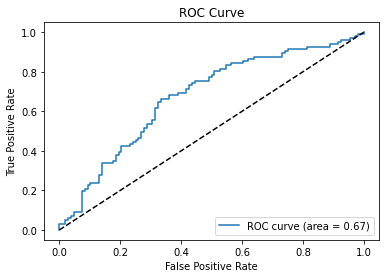

In [6]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from collections import defaultdict
import ast

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# No need to scale features for CatBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and optimize the CatBoost model for GPU
param_grid = {
    'depth': [10],  # Depth of the tree
    'learning_rate': [0.01],  # Learning rate
    'iterations': [1500],  # Number of trees
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # Regularization term
    'border_count': [128],  # Number of splits for numerical features
    'loss_function': ['Logloss', 'CrossEntropy'],  # Loss functions
    'eval_metric': ['AUC'],
    'task_type': ['GPU']  # Enable GPU support, ensure value is within a list
}

# Note: For large parameter grids and datasets, consider using RandomizedSearchCV instead
grid_search = GridSearchCV(
    CatBoostClassifier(random_seed=42, verbose=False, task_type='GPU'),
    param_grid, cv=5, scoring='roc_auc', n_jobs=1, verbose=2
)
grid_search.fit(X_train, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve using probabilities
probabilities = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# No need to scale features for CatBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and optimize the CatBoost model for GPU
param_grid = {
    'depth': [4, 6, 10],  # Depth of the tree
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'iterations': [500, 1000, 1500],  # Number of trees
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # Regularization term
    'border_count': [32, 64, 128],  # Number of splits for numerical features
    'loss_function': ['Logloss', 'CrossEntropy'],  # Loss functions
    'eval_metric': ['AUC'],
    'task_type': 'GPU'  # Enable GPU support
}

# Note: For large parameter grids and datasets, consider using RandomizedSearchCV instead
grid_search = GridSearchCV(CatBoostClassifier(random_seed=42, verbose=False, thread_count=-1, task_type='GPU'), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve using probabilities
probabilities = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [8]:
pip install xgboost

     |████████████████████████████████| 297.1 MB 8.6 MB/s eta 0:00:012     |█████████████████████████▏      | 233.2 MB 11.2 MB/s eta 0:00:06     |██████████████████████████▍     | 245.3 MB 6.8 MB/s eta 0:00:08     |██████████████████████████▌     | 245.8 MB 6.8 MB/s eta 0:00:08
Note: you may need to restart the kernel to use updated packages.


  4%|▍         | 43/1025 [00:00<00:02, 425.53it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 399.61it/s]


Time taken: 3.2167s
Best parameters: {'eval_metric': 'auc', 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'objective': 'binary:logistic', 'reg_lambda': 2}
Accuracy: 0.5804878048780487
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       108
           1       0.56      0.49      0.53        97

    accuracy                           0.58       205
   macro avg       0.58      0.58      0.58       205
weighted avg       0.58      0.58      0.58       205



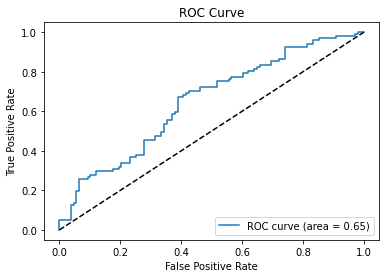

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and optimize the XGBoost model
param_grid = {
    'max_depth': [5],  # Depth of the tree
    'learning_rate': [0.01],  # Learning rate
    'n_estimators': [300],  # Number of trees
    'reg_lambda': [1, 2, 3],  # L2 regularization term on weights
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'objective': ['binary:logistic'],  # Loss function to be minimized
    'eval_metric': ['auc']  # Evaluation metric for validation data
}

# Note: For large parameter grids and datasets, consider using RandomizedSearchCV instead
grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, seed=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve using probabilities
probabilities = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and optimize the XGBoost model
param_grid = {
    'max_depth': [3, 4, 5],  # Depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of trees
    'reg_lambda': [1, 2, 3],  # L2 regularization term on weights
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'objective': ['binary:logistic'],  # Loss function to be minimized
    'eval_metric': ['auc']  # Evaluation metric for validation data
}

# Note: For large parameter grids and datasets, consider using RandomizedSearchCV instead
grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, seed=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve using probabilities
probabilities = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## LightGBM

In [10]:
pip install lightgbm

     |████████████████████████████████| 3.1 MB 2.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


  4%|▍         | 40/1025 [00:00<00:02, 397.30it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 391.71it/s]


Time taken: 3.1896s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 391, number of negative: 429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5199
[LightGBM] [Info] Number of data points in the train set: 820, number of used features: 1733
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476829 -> initscore=-0.092749
[LightGBM] [Info] Start training from score -0.092749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

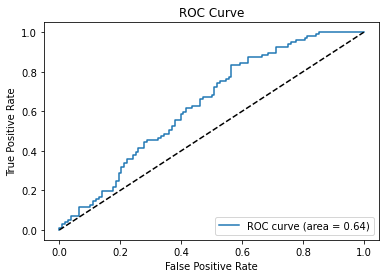

In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from collections import defaultdict
import ast

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'])
global_median_edge = np.median(df_edges['Mean Difference'])

# Extract enhanced features
X = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and optimize the LightGBM model
param_grid = {
    'max_depth': [3, 4, 5],  # Depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of trees
    'reg_lambda': [1, 2, 3],  # L2 regularization term on weights
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'objective': ['binary'],  # Loss function to be minimized
    'metric': ['auc']  # Evaluation metric for validation data
}

# Note: For large parameter grids and datasets, consider using RandomizedSearchCV instead
grid_search = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve using probabilities
probabilities = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from collections import defaultdict
import ast

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def extract_graph_features(graphs):
    features = []
    for g in graphs:
        # Assuming `to_simple_graph` converts DGLGraph to NetworkX graph
        simple_graph = to_simple_graph(g)
        num_nodes = simple_graph.number_of_nodes()
        num_edges = simple_graph.number_of_edges()
        # Example: Add more features based on the graph properties
        features.append([num_nodes, num_edges])
    return np.array(features)

# Placeholder for loading the dataset and graphs
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert graph data to a numerical feature matrix
X = extract_graph_features(graphs)
y = np.array(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and optimize the LightGBM model
param_grid = {
    'max_depth': [3, 4, 5],  # Depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of trees
    'reg_lambda': [1, 2, 3],  # L2 regularization term on weights
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'objective': ['binary'],  # Loss function to be minimized
    'metric': ['auc']  # Evaluation metric for validation data
}

# Note: For large parameter grids and datasets, consider using RandomizedSearchCV instead
grid_search = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluation
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting ROC Curve using probabilities
probabilities = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, probabilities)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

  4%|▍         | 44/1025 [00:00<00:02, 430.89it/s]

[!] Dataset:  Abide100Dataset
[]


100%|██████████| 1025/1025 [00:02<00:00, 431.94it/s]


Time taken: 2.8913s


KeyboardInterrupt: 